<a href="https://colab.research.google.com/github/sungjindo/black_coal_price/blob/main/Xgboost_blackcoal_all.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#0.Module
 
- 파일은 prophet을 통해 각 feature의 예측값을 뽑아낸 뒤에 

xgboost를 통해서 Coal_price 값을 예측해보았다.

- 여기에 추가로 19년도 1월 1일 예측시점부터 하루씩 더해가며 recursive model을 구축하였다.

- model -> prophet 예측값 +xgboost(recursive)
- model -> prophet 예측값 +(t-1시점)Coal_price - predict값을 recursive

In [1]:
# 기본 라이브러리
import pandas as pd
import numpy as np
import os

# 시각화 라이브러리
import matplotlib.pyplot as plt
import seaborn as sns

from plotly.offline import init_notebook_mode, iplot #plotly offline mode 
init_notebook_mode(connected = True)
import plotly.graph_objs as go #plotly graphical object
%matplotlib notebook
%matplotlib inline

# 통계 및 기계학습 관련 라이브러리
from scipy import stats    # 통계 관련 라이브러리
from sklearn.model_selection import train_test_split, RandomizedSearchCV    # 데이터 셋 분류 라이브러리
from sklearn.utils import resample    # 데이터 업샘플링&다운샘플링 라이브러리
from imblearn.over_sampling import RandomOverSampler
from imblearn.combine import SMOTEENN    # 복합샘플링 라이브러리
from sklearn.preprocessing import StandardScaler, MinMaxScaler, RobustScaler    # 데이터 스케일링 라이브러리
from statsmodels.stats.outliers_influence import variance_inflation_factor    # 변수 간 다중공선성 확인(VIF) 라이브러리
from sklearn.metrics import (accuracy_score, confusion_matrix, classification_report, roc_auc_score, roc_curve, auc, plot_confusion_matrix, plot_roc_curve)    # 모델 정확도 검증 라이브러리
from sklearn.model_selection import cross_val_score, train_test_split   # validation  검증 라이브러리

import matplotlib.pyplot as plt
import matplotlib

import statsmodels.api as sm    # 통계분석 관련 라이브러리
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from fbprophet import Prophet


import warnings    # 경고문구 지우기
warnings.filterwarnings("ignore")

# xgboost라이브러리 추가
import xgboost as xgb
from xgboost import plot_importance, plot_tree
from xgboost import XGBClassifier
from datetime import datetime

from google.colab import drive
drive.mount('/content/gdrive')

plt.style.use('fivethirtyeight')

/usr/local/lib/python3.7/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning:

pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.



Mounted at /content/gdrive


#1.Data

*   df는 실제값으로 2018년도 12월 31일까지
*   df_pred는 prophet으로 prediction한 값 2019년부터 1월 1일까지 (Coal_price 제외)
*   df_merge에 예측에 필요한 coal_price값 제외하고 merge






In [2]:
df = pd.read_excel("/content/gdrive/My Drive/Black_coal/data/dataset/project_dataset.xlsx")
df = df.sort_values('date')
df['date']= pd.to_datetime(df['date'])

df = df.set_index('date')
df = df[df.index < '2019-01-01']
df = df.reset_index()
df_pred = pd.read_csv("/content/gdrive/My Drive/Black_coal/data/dataset/prophet_pred/prophet_pred_final.csv", encoding = 'utf-8-sig')
df_pred = df_pred.rename(columns ={'ds':'date'})
df_pred['date']= pd.to_datetime(df_pred['date'])

df_pred = df_pred.set_index('date')
df_pred = df_pred.reset_index()
df_merge = pd.merge(df, df_pred, on=['date', 'Brent_fut', 'iron', 'copper_fut', 'WTI_fut', 'WTI', 'LNG_fut',
       'bdi', 'USD/AUD(호주)', 'USD/CAD(캐나다)', 'USD/COP(콜롬비아)', 'US 달러지수',
       'USD/IDR(인도네시아)', 'USD/RUB(러시아)', 'USD/ZAR(자메이카)', '상하이종합지수', '인도지수',
       '브라질지수', '다우존스지수', '프랑스지수', '영국지수', '독일지수', 'S&P500지수', '항셍지수', '나스닥지수',
       '코스피지수', '니케이225지수', '유로스톡스50지수', '호주지수', '캐나다지수'], how='outer')
       
df_merge = df_merge[['date', 'Coal_price', 'Brent_fut', 'iron', 'copper_fut', 'WTI_fut', 'WTI', 'LNG_fut',
       'bdi', 'USD/AUD(호주)', 'USD/CAD(캐나다)', 'USD/COP(콜롬비아)', 'US 달러지수',
       'USD/IDR(인도네시아)', 'USD/RUB(러시아)', 'USD/ZAR(자메이카)', '상하이종합지수', '인도지수',
       '브라질지수', '다우존스지수', '프랑스지수', '영국지수', '독일지수', 'S&P500지수', '항셍지수', '나스닥지수',
       '코스피지수', '니케이225지수', '유로스톡스50지수', '호주지수', '캐나다지수']]
df_merge['date']= pd.to_datetime(df_merge['date'])
df_drop = df_merge.drop('date',axis=1)
df_coal = pd.read_csv("/content/gdrive/My Drive/Black_coal/data/dataset/project_dataset.csv", encoding = 'utf-8-sig')
df_coal = df_coal.sort_values('date')
df_coal['date']= pd.to_datetime(df_coal['date'])

df_coal = df_coal.set_index('date')
df_coal = df_coal[df_coal.index < '2019-04-01']

df_coal = df_coal.reset_index()
df_coal = df_coal[['date','Coal_price']]

#2.Model

##2.1 recursive (1년 val)

*   30개 변수 prophe prediction 값 
*   y_pred값을 validation셋에 추가


In [ ]:
df_merge = df_merge.set_index('date')

In [ ]:
for i in range (89):
    
  
  # 학습과 테스트 데이터 분리
  split =  len(df_merge[:"2017-12-31"])
  split1 =  len(df_merge[:"2018-12-31"])
  
  df_train = df_drop[:split+i]
  df_test = df_drop[split+i:split1+i]
  df_predict = df_drop[len(df_merge[:"2018-12-31"]):len(df_merge[:"2019-01-01"])]

  df_train_y = df_train.loc[:,'Coal_price']
  df_train_x = df_train.drop('Coal_price', axis=1)
  df_test_y = df_test.loc[:,'Coal_price']
  df_test_x = df_test.drop('Coal_price', axis=1)
  # 나중에 예측값과 비교하기 위해 test 데이터 복제본 저장
  df_test_orig = df_coal.loc[:, 'Coal_price']
  df_predict_x = df_predict.drop('Coal_price', axis=1)
  df_predict_x = df_predict_x[:]



  XG_model_month = xgb.XGBRegressor(learning_rate=0.1,max_depth=6,n_estimators=200)
  XG_model_month.fit(df_train_x, df_train_y, eval_set=[(df_test_x, df_test_y)], early_stopping_rounds=100,verbose=False)
  
  xgboost = XG_model_month.predict(df_predict_x)

  # 실제 값과 예측 값을 하나의 DataFrame으로 만들고 visualize
  result=pd.concat([df_test_orig.reset_index(), pd.DataFrame(xgboost, columns=['xgboost'])], axis=1, ignore_index=False)
  
  df_drop['Coal_price'][len(df_merge[:"2018-12-31"])+i]=result['xgboost'][0]
  # df_drop['shift'][len(df_merge[:"2019-01-01"])+i]=result['xgboost'][0]
  print(df_drop['Coal_price'][len(df_merge[:"2018-12-31"])]+i)
  # print(df_drop['shift'][len(df_merge[:"2019-01-01"])]+i)

[00:22:24] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
97.86166381835938
[00:22:26] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
98.86166381835938
[00:22:28] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
99.86166381835938
[00:22:30] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
100.86166381835938
[00:22:33] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
101.86166381835938
[00:22:37] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
102.86166381835938
[00:22:39] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


###result

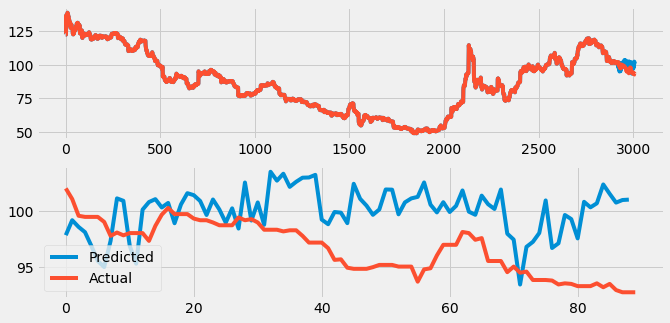

In [ ]:
plt.figure(figsize=(10,5))
plt.subplot(211)
plt.plot(df_drop['Coal_price'].values , label='Predicted')
plt.plot(df_coal['Coal_price'].values , label='Actual')


plt.subplot(212)
plt.plot(df_drop['Coal_price'][-90:].values, label='Predicted')
plt.plot(df_coal['Coal_price'][-90:].values, label='Actual')
plt.legend()
plt.show()

##2.2 recursive / (t-1Coal_price)



*  t-1시점의 y데이터 추가
- recursive model






In [ ]:
df2 = pd.read_excel("/content/gdrive/My Drive/Black_coal/data/dataset/project_dataset.xlsx")
df2 = df2.sort_values('date')
df2['date']= pd.to_datetime(df2['date'])

df2 = df2.set_index('date')
df2 = df2[df2.index < '2019-01-02']
df2 = df2.reset_index()
df2 = df2[['date','Coal_price']] 
df2 = df2.rename(columns ={'date':'ds'})
shift= df2['Coal_price'].shift(1)
shift[0]=df2['Coal_price'][0]

shift2 = df2[['ds','Coal_price']]
shift2=df2.rename(columns={'Coal_price' : 'shift'})
shift2['shift']=shift
shift2



,ds,shift
0,2011-01-01,122.65
1,2011-01-02,122.65
2,2011-01-03,122.65
3,2011-01-04,136.50
4,2011-01-05,137.30
...,...,...
2918,2018-12-28,101.55
2919,2018-12-29,101.90
2920,2018-12-30,101.90
2921,2018-12-31,101.90


In [ ]:
df_merge=df_merge.reset_index()

In [ ]:
df_merge=df_merge.rename(columns={'date':'ds'})
df_merge

,ds,Coal_price,Brent_fut,iron,copper_fut,WTI_fut,WTI,LNG_fut,bdi,USD/AUD(호주),...,영국지수,독일지수,S&P500지수,항셍지수,나스닥지수,코스피지수,니케이225지수,유로스톡스50지수,호주지수,캐나다지수
0,2011-01-01,122.65,94.750000,168.300000,9644.000000,91.380000,91.400000,61.070000,1773.000000,0.984470,...,5899.899902,6914.189941,1257.640015,23035.449219,2652.870117,2051.000000,10228.919922,2807.040039,4745.200195,13443.200195
1,2011-01-02,122.65,94.750000,168.300000,9644.000000,91.380000,91.400000,61.070000,1773.000000,0.984470,...,5899.899902,6914.189941,1257.640015,23035.449219,2652.870117,2051.000000,10228.919922,2807.040039,4745.200195,13443.200195
2,2011-01-03,136.50,94.840000,170.000000,9644.000000,91.550000,91.560000,61.070000,1773.000000,0.979010,...,5899.899902,6989.740234,1271.869995,23436.050781,2691.520020,2070.080078,10228.919922,2839.429932,4745.200195,13443.200195
3,2011-01-04,137.30,93.530000,172.100000,9619.250000,89.380000,89.230000,58.320000,1693.000000,0.983370,...,6013.899902,6975.350098,1270.199951,23668.480469,2681.250000,2085.139893,10398.099609,2844.169922,4742.500000,13402.299805
4,2011-01-05,130.65,95.500000,174.500000,9586.000000,90.300000,90.380000,56.400000,1621.000000,0.992850,...,6043.899902,6939.819824,1276.560059,23757.820312,2702.199951,2082.550049,10380.769531,2833.739990,4714.899902,13396.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3007,2019-03-27,NaN,84.124730,72.446181,6703.428741,74.566090,74.733597,71.442419,1402.027680,1.372171,...,7298.123222,11897.295010,2918.493060,29237.210404,8123.580208,2252.528334,23546.358166,3263.093898,6171.147374,15954.943396
3008,2019-03-28,NaN,84.199753,72.354536,6691.270487,74.562116,74.750119,71.307777,1399.854283,1.373349,...,7290.969546,11893.885654,2919.238593,29209.282776,8123.496620,2252.020118,23542.239644,3261.886242,6175.229169,15943.334716
3009,2019-03-29,NaN,84.291781,72.370737,6683.270496,74.628844,74.817677,71.206234,1396.475330,1.374941,...,7287.452489,11888.538235,2919.920821,29195.805869,8122.842283,2249.926048,23541.187552,3259.948145,6176.074040,15927.833254
3010,2019-03-30,NaN,84.363165,72.375087,6673.171699,74.731828,74.938001,71.049927,1390.815421,1.376403,...,7283.986305,11884.435037,2920.547457,29173.373865,8122.769151,2247.524109,23537.235686,3257.373048,6176.594855,15915.512454


In [ ]:
df_merge = pd.merge(df_merge,shift2,on='ds',how='outer')
df_merge

,ds,Coal_price,Brent_fut,iron,copper_fut,WTI_fut,WTI,LNG_fut,bdi,USD/AUD(호주),...,독일지수,S&P500지수,항셍지수,나스닥지수,코스피지수,니케이225지수,유로스톡스50지수,호주지수,캐나다지수,shift
0,2011-01-01,122.65,94.750000,168.300000,9644.000000,91.380000,91.400000,61.070000,1773.000000,0.984470,...,6914.189941,1257.640015,23035.449219,2652.870117,2051.000000,10228.919922,2807.040039,4745.200195,13443.200195,122.65
1,2011-01-02,122.65,94.750000,168.300000,9644.000000,91.380000,91.400000,61.070000,1773.000000,0.984470,...,6914.189941,1257.640015,23035.449219,2652.870117,2051.000000,10228.919922,2807.040039,4745.200195,13443.200195,122.65
2,2011-01-03,136.50,94.840000,170.000000,9644.000000,91.550000,91.560000,61.070000,1773.000000,0.979010,...,6989.740234,1271.869995,23436.050781,2691.520020,2070.080078,10228.919922,2839.429932,4745.200195,13443.200195,122.65
3,2011-01-04,137.30,93.530000,172.100000,9619.250000,89.380000,89.230000,58.320000,1693.000000,0.983370,...,6975.350098,1270.199951,23668.480469,2681.250000,2085.139893,10398.099609,2844.169922,4742.500000,13402.299805,136.50
4,2011-01-05,130.65,95.500000,174.500000,9586.000000,90.300000,90.380000,56.400000,1621.000000,0.992850,...,6939.819824,1276.560059,23757.820312,2702.199951,2082.550049,10380.769531,2833.739990,4714.899902,13396.000000,137.30
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3007,2019-03-27,NaN,84.124730,72.446181,6703.428741,74.566090,74.733597,71.442419,1402.027680,1.372171,...,11897.295010,2918.493060,29237.210404,8123.580208,2252.528334,23546.358166,3263.093898,6171.147374,15954.943396,NaN
3008,2019-03-28,NaN,84.199753,72.354536,6691.270487,74.562116,74.750119,71.307777,1399.854283,1.373349,...,11893.885654,2919.238593,29209.282776,8123.496620,2252.020118,23542.239644,3261.886242,6175.229169,15943.334716,NaN
3009,2019-03-29,NaN,84.291781,72.370737,6683.270496,74.628844,74.817677,71.206234,1396.475330,1.374941,...,11888.538235,2919.920821,29195.805869,8122.842283,2249.926048,23541.187552,3259.948145,6176.074040,15927.833254,NaN
3010,2019-03-30,NaN,84.363165,72.375087,6673.171699,74.731828,74.938001,71.049927,1390.815421,1.376403,...,11884.435037,2920.547457,29173.373865,8122.769151,2247.524109,23537.235686,3257.373048,6176.594855,15915.512454,NaN


In [ ]:
df_drop = df_merge.drop('ds',axis=1)

In [ ]:
df_merge=df_merge.set_index('ds')

In [ ]:
for i in range (89):
    
  
  # 학습과 테스트 데이터 분리
  split =  len(df_merge[:"2017-12-31"])
  split1 =  len(df_merge[:"2018-12-31"])
  
  df_train = df_drop[:split+i]
  df_test = df_drop[split+i:split1+i]
  df_predict = df_drop[len(df_merge[:"2018-12-31"]):len(df_merge[:"2019-01-01"])]

  df_train_y = df_train.loc[:,'Coal_price']
  df_train_x = df_train.drop('Coal_price', axis=1)
  df_test_y = df_test.loc[:,'Coal_price']
  df_test_x = df_test.drop('Coal_price', axis=1)
  # 나중에 예측값과 비교하기 위해 test 데이터 복제본 저장
  df_test_orig = df_coal.loc[:, 'Coal_price']
  df_predict_x = df_predict.drop('Coal_price', axis=1)
  df_predict_x = df_predict_x[:]



  XG_model_month = xgb.XGBRegressor(learning_rate=0.1,max_depth=6,n_estimators=200)
  XG_model_month.fit(df_train_x, df_train_y, eval_set=[(df_test_x, df_test_y)], early_stopping_rounds=100,verbose=False)
  
  xgboost = XG_model_month.predict(df_predict_x)

  # 실제 값과 예측 값을 하나의 DataFrame으로 만들고 visualize
  result=pd.concat([df_test_orig.reset_index(), pd.DataFrame(xgboost, columns=['xgboost'])], axis=1, ignore_index=False)
  
  df_drop['Coal_price'][len(df_merge[:"2018-12-31"])+i]=result['xgboost'][0]
  df_drop['shift'][len(df_merge[:"2019-01-01"])+i]=result['xgboost'][0]
  print(df_drop['Coal_price'][len(df_merge[:"2018-12-31"])]+i)
  print(df_drop['shift'][len(df_merge[:"2019-01-01"])]+i)

[00:27:06] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
102.97969818115234
102.97969818115234
[00:27:07] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
103.97969818115234
103.97969818115234
[00:27:09] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
104.97969818115234
104.97969818115234
[00:27:11] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
105.97969818115234
105.97969818115234
[00:27:13] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
106.97969818115234
106.97969818115234
[00:27:15] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
107.97969818115234
107.97969818115234
[00:27:17]

###result

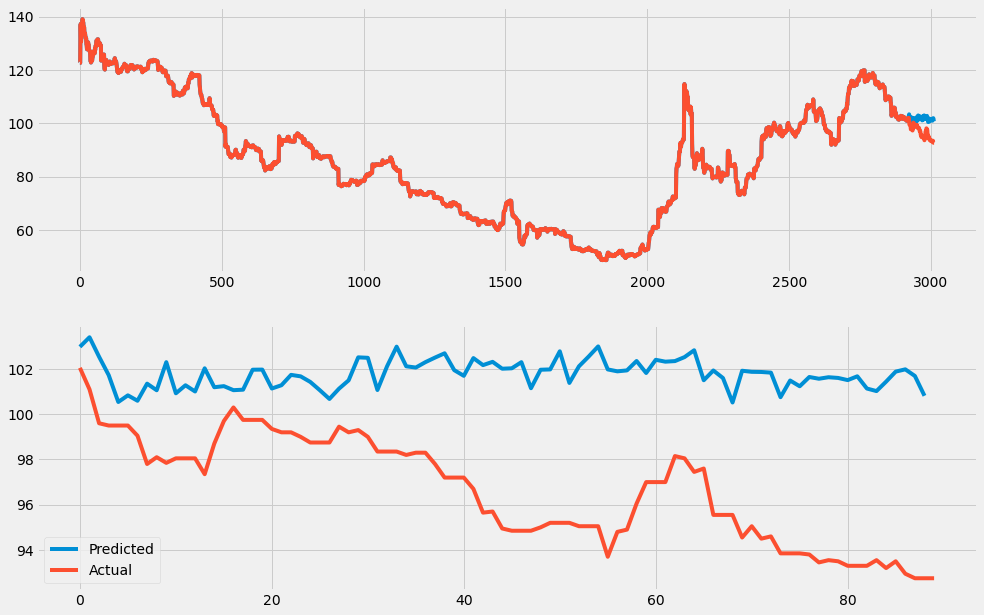

In [ ]:
plt.figure(figsize=(15,10))
plt.subplot(211)
plt.plot(df_drop['Coal_price'].values , label='Predicted')
plt.plot(df_coal['Coal_price'].values , label='Actual')


plt.subplot(212)
plt.plot(df_drop['Coal_price'][-90:].values, label='Predicted')
plt.plot(df_coal['Coal_price'][-90:].values, label='Actual')
plt.legend()
plt.show()

##2.3 recursive(3month val)

*   30개 변수 prophe prediction 값 
*   y_pred값을 validation셋에 추가


Data

*   df는 실제값으로 2018년도 12월 31일까지
*   df_pred는 prophet으로 prediction한 값 2019년부터 1월 1일까지 (Coal_price 제외)
*   df_merge에 예측에 필요한 coal_price값 제외하고 merge






In [ ]:
df = pd.read_excel("/content/gdrive/My Drive/Black_coal/data/dataset/project_dataset.xlsx")
df = df.sort_values('date')
df['date']= pd.to_datetime(df['date'])

df = df.set_index('date')
df = df[df.index < '2019-01-01']
df = df.reset_index()
df  

,date,Coal_price,iron,Brent_fut,copper_fut,WTI_fut,WTI,LNG_fut,bdi,USD/AUD(호주),...,영국지수,독일지수,S&P500지수,항셍지수,나스닥지수,코스피지수,니케이225지수,유로스톡스50지수,호주지수,캐나다지수
0,2011-01-01,122.65,168.3,94.75,9644.00,91.38,91.40,61.07,1773.0,0.98447,...,5899.899902,6914.189941,1257.640015,23035.449219,2652.870117,2051.000000,10228.919922,2807.040039,4745.200195,13443.200195
1,2011-01-02,122.65,168.3,94.75,9644.00,91.38,91.40,61.07,1773.0,0.98447,...,5899.899902,6914.189941,1257.640015,23035.449219,2652.870117,2051.000000,10228.919922,2807.040039,4745.200195,13443.200195
2,2011-01-03,136.50,170.0,94.84,9644.00,91.55,91.56,61.07,1773.0,0.97901,...,5899.899902,6989.740234,1271.869995,23436.050781,2691.520020,2070.080078,10228.919922,2839.429932,4745.200195,13443.200195
3,2011-01-04,137.30,172.1,93.53,9619.25,89.38,89.23,58.32,1693.0,0.98337,...,6013.899902,6975.350098,1270.199951,23668.480469,2681.250000,2085.139893,10398.099609,2844.169922,4742.500000,13402.299805
4,2011-01-05,130.65,174.5,95.50,9586.00,90.30,90.38,56.40,1621.0,0.99285,...,6043.899902,6939.819824,1276.560059,23757.820312,2702.199951,2082.550049,10380.769531,2833.739990,4714.899902,13396.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2917,2018-12-27,101.55,69.0,52.16,5972.00,44.61,45.23,64.36,1271.0,1.41347,...,6584.700195,10381.509766,2488.830078,25478.880859,6579.490234,2028.439941,20077.619141,2937.360107,5597.200195,14165.200195
2918,2018-12-28,101.90,69.2,52.20,5992.25,45.33,44.92,62.63,1271.0,1.42140,...,6734.000000,10558.959961,2485.739990,25504.199219,6584.520020,2041.040039,20014.769531,2986.530029,5654.299805,14222.000000
2919,2018-12-29,101.90,69.2,52.20,5992.25,45.33,44.92,62.63,1271.0,1.42140,...,6734.000000,10558.959961,2485.739990,25504.199219,6584.520020,2041.040039,20014.769531,2986.530029,5654.299805,14222.000000
2920,2018-12-30,101.90,69.2,52.20,5992.25,45.33,45.34,62.63,1271.0,1.42140,...,6734.000000,10558.959961,2485.739990,25504.199219,6584.520020,2041.040039,20014.769531,2986.530029,5654.299805,14222.000000


In [ ]:
df_pred = pd.read_csv("/content/gdrive/My Drive/Black_coal/data/dataset/prophet_pred/prophet_pred_final.csv", encoding = 'utf-8-sig')
df_pred = df_pred.rename(columns ={'ds':'date'})
df_pred['date']= pd.to_datetime(df_pred['date'])

df_pred = df_pred.set_index('date')
df_pred = df_pred.reset_index()
df_pred

,date,Brent_fut,iron,copper_fut,WTI_fut,WTI,LNG_fut,bdi,USD/AUD(호주),USD/CAD(캐나다),...,영국지수,독일지수,S&P500지수,항셍지수,나스닥지수,코스피지수,니케이225지수,유로스톡스50지수,호주지수,캐나다지수
0,2019-01-01,75.812228,71.545954,6619.631419,66.938042,66.994911,70.338440,1544.769285,1.381137,1.304337,...,7288.361045,11940.424072,2850.111402,28692.519075,7811.282865,2235.177588,23500.663279,3266.153594,6065.461711,15684.428936
1,2019-01-02,76.057960,71.975804,6620.989242,67.089308,67.144982,70.440536,1537.793650,1.379890,1.303019,...,7298.230085,11961.280178,2858.950798,28764.780039,7844.147829,2238.647614,23578.059165,3268.671637,6078.348331,15717.862805
2,2019-01-03,76.142337,72.191391,6626.679451,67.154771,67.230336,70.546706,1527.818872,1.379584,1.301855,...,7304.254455,11973.726891,2866.271727,28815.469475,7869.908366,2241.715687,23638.259125,3269.909214,6089.633134,15746.566127
3,2019-01-04,76.257750,72.401154,6634.778046,67.287031,67.354341,70.672519,1516.018237,1.379166,1.300963,...,7312.470514,11978.516388,2871.711769,28879.213400,7889.392367,2243.873936,23690.803718,3269.718077,6094.977334,15766.852091
4,2019-01-05,76.299317,72.574080,6635.657939,67.374272,67.447421,70.721252,1501.790617,1.378242,1.300217,...,7316.875265,11977.567232,2875.054906,28918.499131,7903.145770,2246.051368,23722.119596,3267.760779,6096.839291,15780.126382
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
85,2019-03-27,84.124730,72.446181,6703.428741,74.566090,74.733597,71.442419,1402.027680,1.372171,1.323902,...,7298.123222,11897.295010,2918.493060,29237.210404,8123.580208,2252.528334,23546.358166,3263.093898,6171.147374,15954.943396
86,2019-03-28,84.199753,72.354536,6691.270487,74.562116,74.750119,71.307777,1399.854283,1.373349,1.323854,...,7290.969546,11893.885654,2919.238593,29209.282776,8123.496620,2252.020118,23542.239644,3261.886242,6175.229169,15943.334716
87,2019-03-29,84.291781,72.370737,6683.270496,74.628844,74.817677,71.206234,1396.475330,1.374941,1.323919,...,7287.452489,11888.538235,2919.920821,29195.805869,8122.842283,2249.926048,23541.187552,3259.948145,6176.074040,15927.833254
88,2019-03-30,84.363165,72.375087,6673.171699,74.731828,74.938001,71.049927,1390.815421,1.376403,1.323784,...,7283.986305,11884.435037,2920.547457,29173.373865,8122.769151,2247.524109,23537.235686,3257.373048,6176.594855,15915.512454


In [ ]:
df_merge = pd.merge(df, df_pred, on=['date', 'Brent_fut', 'iron', 'copper_fut', 'WTI_fut', 'WTI', 'LNG_fut',
       'bdi', 'USD/AUD(호주)', 'USD/CAD(캐나다)', 'USD/COP(콜롬비아)', 'US 달러지수',
       'USD/IDR(인도네시아)', 'USD/RUB(러시아)', 'USD/ZAR(자메이카)', '상하이종합지수', '인도지수',
       '브라질지수', '다우존스지수', '프랑스지수', '영국지수', '독일지수', 'S&P500지수', '항셍지수', '나스닥지수',
       '코스피지수', '니케이225지수', '유로스톡스50지수', '호주지수', '캐나다지수'], how='outer')
       
df_merge = df_merge[['date', 'Coal_price', 'Brent_fut', 'iron', 'copper_fut', 'WTI_fut', 'WTI', 'LNG_fut',
       'bdi', 'USD/AUD(호주)', 'USD/CAD(캐나다)', 'USD/COP(콜롬비아)', 'US 달러지수',
       'USD/IDR(인도네시아)', 'USD/RUB(러시아)', 'USD/ZAR(자메이카)', '상하이종합지수', '인도지수',
       '브라질지수', '다우존스지수', '프랑스지수', '영국지수', '독일지수', 'S&P500지수', '항셍지수', '나스닥지수',
       '코스피지수', '니케이225지수', '유로스톡스50지수', '호주지수', '캐나다지수']]
df_merge['date']= pd.to_datetime(df_merge['date'])

df_merge

,date,Coal_price,Brent_fut,iron,copper_fut,WTI_fut,WTI,LNG_fut,bdi,USD/AUD(호주),...,영국지수,독일지수,S&P500지수,항셍지수,나스닥지수,코스피지수,니케이225지수,유로스톡스50지수,호주지수,캐나다지수
0,2011-01-01,122.65,94.750000,168.300000,9644.000000,91.380000,91.400000,61.070000,1773.000000,0.984470,...,5899.899902,6914.189941,1257.640015,23035.449219,2652.870117,2051.000000,10228.919922,2807.040039,4745.200195,13443.200195
1,2011-01-02,122.65,94.750000,168.300000,9644.000000,91.380000,91.400000,61.070000,1773.000000,0.984470,...,5899.899902,6914.189941,1257.640015,23035.449219,2652.870117,2051.000000,10228.919922,2807.040039,4745.200195,13443.200195
2,2011-01-03,136.50,94.840000,170.000000,9644.000000,91.550000,91.560000,61.070000,1773.000000,0.979010,...,5899.899902,6989.740234,1271.869995,23436.050781,2691.520020,2070.080078,10228.919922,2839.429932,4745.200195,13443.200195
3,2011-01-04,137.30,93.530000,172.100000,9619.250000,89.380000,89.230000,58.320000,1693.000000,0.983370,...,6013.899902,6975.350098,1270.199951,23668.480469,2681.250000,2085.139893,10398.099609,2844.169922,4742.500000,13402.299805
4,2011-01-05,130.65,95.500000,174.500000,9586.000000,90.300000,90.380000,56.400000,1621.000000,0.992850,...,6043.899902,6939.819824,1276.560059,23757.820312,2702.199951,2082.550049,10380.769531,2833.739990,4714.899902,13396.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3007,2019-03-27,NaN,84.124730,72.446181,6703.428741,74.566090,74.733597,71.442419,1402.027680,1.372171,...,7298.123222,11897.295010,2918.493060,29237.210404,8123.580208,2252.528334,23546.358166,3263.093898,6171.147374,15954.943396
3008,2019-03-28,NaN,84.199753,72.354536,6691.270487,74.562116,74.750119,71.307777,1399.854283,1.373349,...,7290.969546,11893.885654,2919.238593,29209.282776,8123.496620,2252.020118,23542.239644,3261.886242,6175.229169,15943.334716
3009,2019-03-29,NaN,84.291781,72.370737,6683.270496,74.628844,74.817677,71.206234,1396.475330,1.374941,...,7287.452489,11888.538235,2919.920821,29195.805869,8122.842283,2249.926048,23541.187552,3259.948145,6176.074040,15927.833254
3010,2019-03-30,NaN,84.363165,72.375087,6673.171699,74.731828,74.938001,71.049927,1390.815421,1.376403,...,7283.986305,11884.435037,2920.547457,29173.373865,8122.769151,2247.524109,23537.235686,3257.373048,6176.594855,15915.512454


In [ ]:
df_drop = df_merge.drop('date',axis=1)
df_drop

,Coal_price,Brent_fut,iron,copper_fut,WTI_fut,WTI,LNG_fut,bdi,USD/AUD(호주),USD/CAD(캐나다),...,영국지수,독일지수,S&P500지수,항셍지수,나스닥지수,코스피지수,니케이225지수,유로스톡스50지수,호주지수,캐나다지수
0,122.65,94.750000,168.300000,9644.000000,91.380000,91.400000,61.070000,1773.000000,0.984470,0.999600,...,5899.899902,6914.189941,1257.640015,23035.449219,2652.870117,2051.000000,10228.919922,2807.040039,4745.200195,13443.200195
1,122.65,94.750000,168.300000,9644.000000,91.380000,91.400000,61.070000,1773.000000,0.984470,0.999600,...,5899.899902,6914.189941,1257.640015,23035.449219,2652.870117,2051.000000,10228.919922,2807.040039,4745.200195,13443.200195
2,136.50,94.840000,170.000000,9644.000000,91.550000,91.560000,61.070000,1773.000000,0.979010,0.992700,...,5899.899902,6989.740234,1271.869995,23436.050781,2691.520020,2070.080078,10228.919922,2839.429932,4745.200195,13443.200195
3,137.30,93.530000,172.100000,9619.250000,89.380000,89.230000,58.320000,1693.000000,0.983370,0.992390,...,6013.899902,6975.350098,1270.199951,23668.480469,2681.250000,2085.139893,10398.099609,2844.169922,4742.500000,13402.299805
4,130.65,95.500000,174.500000,9586.000000,90.300000,90.380000,56.400000,1621.000000,0.992850,0.997000,...,6043.899902,6939.819824,1276.560059,23757.820312,2702.199951,2082.550049,10380.769531,2833.739990,4714.899902,13396.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3007,NaN,84.124730,72.446181,6703.428741,74.566090,74.733597,71.442419,1402.027680,1.372171,1.323902,...,7298.123222,11897.295010,2918.493060,29237.210404,8123.580208,2252.528334,23546.358166,3263.093898,6171.147374,15954.943396
3008,NaN,84.199753,72.354536,6691.270487,74.562116,74.750119,71.307777,1399.854283,1.373349,1.323854,...,7290.969546,11893.885654,2919.238593,29209.282776,8123.496620,2252.020118,23542.239644,3261.886242,6175.229169,15943.334716
3009,NaN,84.291781,72.370737,6683.270496,74.628844,74.817677,71.206234,1396.475330,1.374941,1.323919,...,7287.452489,11888.538235,2919.920821,29195.805869,8122.842283,2249.926048,23541.187552,3259.948145,6176.074040,15927.833254
3010,NaN,84.363165,72.375087,6673.171699,74.731828,74.938001,71.049927,1390.815421,1.376403,1.323784,...,7283.986305,11884.435037,2920.547457,29173.373865,8122.769151,2247.524109,23537.235686,3257.373048,6176.594855,15915.512454


In [ ]:
df_coal = pd.read_csv("/content/gdrive/My Drive/Black_coal/data/dataset/project_dataset.csv", encoding = 'utf-8-sig')
df_coal = df_coal.sort_values('date')
df_coal['date']= pd.to_datetime(df_coal['date'])

df_coal = df_coal.set_index('date')
df_coal = df_coal[df_coal.index < '2019-04-01']

df_coal = df_coal.reset_index()
df_coal = df_coal[['date','Coal_price']]
df_coal

,date,Coal_price
0,2011-01-01,122.65
1,2011-01-02,122.65
2,2011-01-03,136.50
3,2011-01-04,137.30
4,2011-01-05,130.65
...,...,...
3007,2019-03-27,93.50
3008,2019-03-28,92.95
3009,2019-03-29,92.75
3010,2019-03-30,92.75


In [ ]:
df_merge = df_merge.set_index('date')

In [ ]:
for i in range (89):
    
  
  # 학습과 테스트 데이터 분리
  split =  len(df_merge[:"2018-09-30"])
  split1 =  len(df_merge[:"2018-12-31"])
  
  df_train = df_drop[:split+i]
  df_test = df_drop[split+i:split1+i]
  df_predict = df_drop[len(df_merge[:"2018-12-31"]):len(df_merge[:"2019-01-01"])]

  df_train_y = df_train.loc[:,'Coal_price']
  df_train_x = df_train.drop('Coal_price', axis=1)
  df_test_y = df_test.loc[:,'Coal_price']
  df_test_x = df_test.drop('Coal_price', axis=1)
  # 나중에 예측값과 비교하기 위해 test 데이터 복제본 저장
  df_test_orig = df_coal.loc[:, 'Coal_price']
  df_predict_x = df_predict.drop('Coal_price', axis=1)
  df_predict_x = df_predict_x[:]



  XG_model_month = xgb.XGBRegressor(learning_rate=0.1,max_depth=6,n_estimators=200)
  XG_model_month.fit(df_train_x, df_train_y, eval_set=[(df_test_x, df_test_y)], early_stopping_rounds=100,verbose=False)
  
  xgboost = XG_model_month.predict(df_predict_x)

  # 실제 값과 예측 값을 하나의 DataFrame으로 만들고 visualize
  result=pd.concat([df_test_orig.reset_index(), pd.DataFrame(xgboost, columns=['xgboost'])], axis=1, ignore_index=False)
  
  df_drop['Coal_price'][len(df_merge[:"2018-12-31"])+i]=result['xgboost'][0]
  # df_drop['shift'][len(df_merge[:"2019-01-01"])+i]=result['xgboost'][0]
  print(df_drop['Coal_price'][len(df_merge[:"2018-12-31"])]+i)
  # print(df_drop['shift'][len(df_merge[:"2019-01-01"])]+i)

[00:30:33] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
112.48212432861328
[00:30:35] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
113.48212432861328
[00:30:37] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
114.48212432861328
[00:30:39] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
115.48212432861328
[00:30:40] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
116.48212432861328
[00:30:42] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
117.48212432861328
[00:30:44] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederro

###result

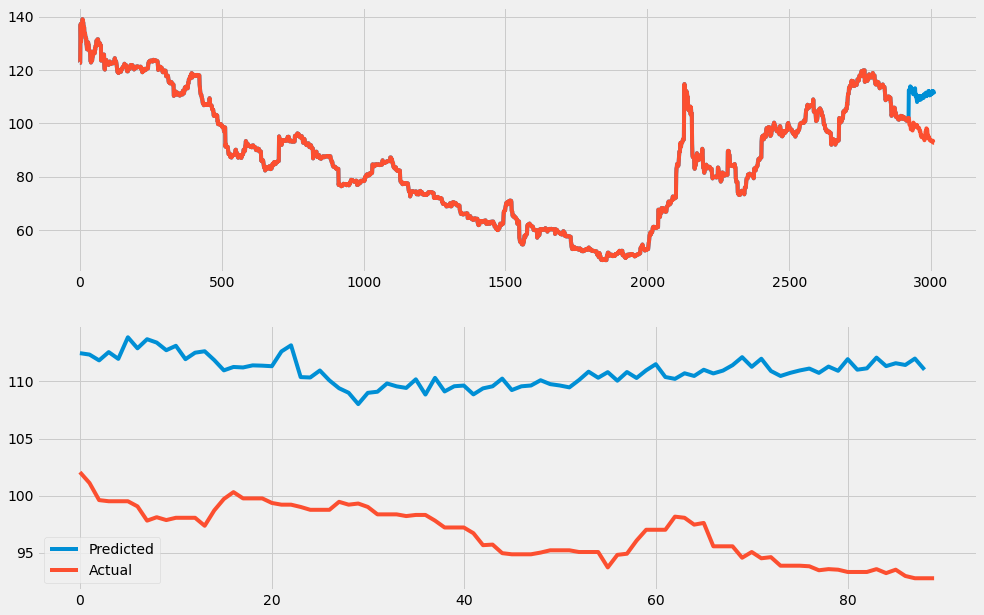

In [ ]:
plt.figure(figsize=(15,10))
plt.subplot(211)
plt.plot(df_drop['Coal_price'].values , label='Predicted')
plt.plot(df_coal['Coal_price'].values , label='Actual')


plt.subplot(212)
plt.plot(df_drop['Coal_price'][-90:].values, label='Predicted')
plt.plot(df_coal['Coal_price'][-90:].values, label='Actual')
plt.legend()
plt.show()

## 2.4 recursive/(t-1/3month val)



*  t-1시점의 y데이터 추가
- recursive model






In [ ]:
df2 = pd.read_excel("/content/gdrive/My Drive/Black_coal/data/dataset/project_dataset.xlsx")
df2 = df2.sort_values('date')
df2['date']= pd.to_datetime(df2['date'])

df2 = df2.set_index('date')
df2 = df2[df2.index < '2019-01-02']
df2 = df2.reset_index()
df2 = df2[['date','Coal_price']] 
df2 = df2.rename(columns ={'date':'ds'})
shift= df2['Coal_price'].shift(1)
shift[0]=df2['Coal_price'][0]

shift2 = df2[['ds','Coal_price']]
shift2=df2.rename(columns={'Coal_price' : 'shift'})
shift2['shift']=shift
shift2



,ds,shift
0,2011-01-01,122.65
1,2011-01-02,122.65
2,2011-01-03,122.65
3,2011-01-04,136.50
4,2011-01-05,137.30
...,...,...
2918,2018-12-28,101.55
2919,2018-12-29,101.90
2920,2018-12-30,101.90
2921,2018-12-31,101.90


In [ ]:
df_merge=df_merge.reset_index()

In [ ]:
df_merge=df_merge.rename(columns={'date':'ds'})
df_merge

,ds,Coal_price,Brent_fut,iron,copper_fut,WTI_fut,WTI,LNG_fut,bdi,USD/AUD(호주),...,영국지수,독일지수,S&P500지수,항셍지수,나스닥지수,코스피지수,니케이225지수,유로스톡스50지수,호주지수,캐나다지수
0,2011-01-01,122.65,94.750000,168.300000,9644.000000,91.380000,91.400000,61.070000,1773.000000,0.984470,...,5899.899902,6914.189941,1257.640015,23035.449219,2652.870117,2051.000000,10228.919922,2807.040039,4745.200195,13443.200195
1,2011-01-02,122.65,94.750000,168.300000,9644.000000,91.380000,91.400000,61.070000,1773.000000,0.984470,...,5899.899902,6914.189941,1257.640015,23035.449219,2652.870117,2051.000000,10228.919922,2807.040039,4745.200195,13443.200195
2,2011-01-03,136.50,94.840000,170.000000,9644.000000,91.550000,91.560000,61.070000,1773.000000,0.979010,...,5899.899902,6989.740234,1271.869995,23436.050781,2691.520020,2070.080078,10228.919922,2839.429932,4745.200195,13443.200195
3,2011-01-04,137.30,93.530000,172.100000,9619.250000,89.380000,89.230000,58.320000,1693.000000,0.983370,...,6013.899902,6975.350098,1270.199951,23668.480469,2681.250000,2085.139893,10398.099609,2844.169922,4742.500000,13402.299805
4,2011-01-05,130.65,95.500000,174.500000,9586.000000,90.300000,90.380000,56.400000,1621.000000,0.992850,...,6043.899902,6939.819824,1276.560059,23757.820312,2702.199951,2082.550049,10380.769531,2833.739990,4714.899902,13396.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3007,2019-03-27,NaN,84.124730,72.446181,6703.428741,74.566090,74.733597,71.442419,1402.027680,1.372171,...,7298.123222,11897.295010,2918.493060,29237.210404,8123.580208,2252.528334,23546.358166,3263.093898,6171.147374,15954.943396
3008,2019-03-28,NaN,84.199753,72.354536,6691.270487,74.562116,74.750119,71.307777,1399.854283,1.373349,...,7290.969546,11893.885654,2919.238593,29209.282776,8123.496620,2252.020118,23542.239644,3261.886242,6175.229169,15943.334716
3009,2019-03-29,NaN,84.291781,72.370737,6683.270496,74.628844,74.817677,71.206234,1396.475330,1.374941,...,7287.452489,11888.538235,2919.920821,29195.805869,8122.842283,2249.926048,23541.187552,3259.948145,6176.074040,15927.833254
3010,2019-03-30,NaN,84.363165,72.375087,6673.171699,74.731828,74.938001,71.049927,1390.815421,1.376403,...,7283.986305,11884.435037,2920.547457,29173.373865,8122.769151,2247.524109,23537.235686,3257.373048,6176.594855,15915.512454


In [ ]:
df_merge = pd.merge(df_merge,shift2,on='ds',how='outer')
df_merge

,ds,Coal_price,Brent_fut,iron,copper_fut,WTI_fut,WTI,LNG_fut,bdi,USD/AUD(호주),...,독일지수,S&P500지수,항셍지수,나스닥지수,코스피지수,니케이225지수,유로스톡스50지수,호주지수,캐나다지수,shift
0,2011-01-01,122.65,94.750000,168.300000,9644.000000,91.380000,91.400000,61.070000,1773.000000,0.984470,...,6914.189941,1257.640015,23035.449219,2652.870117,2051.000000,10228.919922,2807.040039,4745.200195,13443.200195,122.65
1,2011-01-02,122.65,94.750000,168.300000,9644.000000,91.380000,91.400000,61.070000,1773.000000,0.984470,...,6914.189941,1257.640015,23035.449219,2652.870117,2051.000000,10228.919922,2807.040039,4745.200195,13443.200195,122.65
2,2011-01-03,136.50,94.840000,170.000000,9644.000000,91.550000,91.560000,61.070000,1773.000000,0.979010,...,6989.740234,1271.869995,23436.050781,2691.520020,2070.080078,10228.919922,2839.429932,4745.200195,13443.200195,122.65
3,2011-01-04,137.30,93.530000,172.100000,9619.250000,89.380000,89.230000,58.320000,1693.000000,0.983370,...,6975.350098,1270.199951,23668.480469,2681.250000,2085.139893,10398.099609,2844.169922,4742.500000,13402.299805,136.50
4,2011-01-05,130.65,95.500000,174.500000,9586.000000,90.300000,90.380000,56.400000,1621.000000,0.992850,...,6939.819824,1276.560059,23757.820312,2702.199951,2082.550049,10380.769531,2833.739990,4714.899902,13396.000000,137.30
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3007,2019-03-27,NaN,84.124730,72.446181,6703.428741,74.566090,74.733597,71.442419,1402.027680,1.372171,...,11897.295010,2918.493060,29237.210404,8123.580208,2252.528334,23546.358166,3263.093898,6171.147374,15954.943396,NaN
3008,2019-03-28,NaN,84.199753,72.354536,6691.270487,74.562116,74.750119,71.307777,1399.854283,1.373349,...,11893.885654,2919.238593,29209.282776,8123.496620,2252.020118,23542.239644,3261.886242,6175.229169,15943.334716,NaN
3009,2019-03-29,NaN,84.291781,72.370737,6683.270496,74.628844,74.817677,71.206234,1396.475330,1.374941,...,11888.538235,2919.920821,29195.805869,8122.842283,2249.926048,23541.187552,3259.948145,6176.074040,15927.833254,NaN
3010,2019-03-30,NaN,84.363165,72.375087,6673.171699,74.731828,74.938001,71.049927,1390.815421,1.376403,...,11884.435037,2920.547457,29173.373865,8122.769151,2247.524109,23537.235686,3257.373048,6176.594855,15915.512454,NaN


In [ ]:
df_drop = df_merge.drop('ds',axis=1)

In [ ]:
df_merge=df_merge.set_index('ds')

In [ ]:
for i in range (89):
    
  
  # 학습과 테스트 데이터 분리
  split =  len(df_merge[:"2018-09-30"])
  split1 =  len(df_merge[:"2018-12-31"])
  
  df_train = df_drop[:split+i]
  df_test = df_drop[split+i:split1+i]
  df_predict = df_drop[len(df_merge[:"2018-12-31"]):len(df_merge[:"2019-01-01"])]

  df_train_y = df_train.loc[:,'Coal_price']
  df_train_x = df_train.drop('Coal_price', axis=1)
  df_test_y = df_test.loc[:,'Coal_price']
  df_test_x = df_test.drop('Coal_price', axis=1)
  # 나중에 예측값과 비교하기 위해 test 데이터 복제본 저장
  df_test_orig = df_coal.loc[:, 'Coal_price']
  df_predict_x = df_predict.drop('Coal_price', axis=1)
  df_predict_x = df_predict_x[:]



  XG_model_month = xgb.XGBRegressor(learning_rate=0.1,max_depth=6,n_estimators=200)
  XG_model_month.fit(df_train_x, df_train_y, eval_set=[(df_test_x, df_test_y)], early_stopping_rounds=100,verbose=False)
  
  xgboost = XG_model_month.predict(df_predict_x)

  # 실제 값과 예측 값을 하나의 DataFrame으로 만들고 visualize
  result=pd.concat([df_test_orig.reset_index(), pd.DataFrame(xgboost, columns=['xgboost'])], axis=1, ignore_index=False)
  
  df_drop['Coal_price'][len(df_merge[:"2018-12-31"])+i]=result['xgboost'][0]
  df_drop['shift'][len(df_merge[:"2019-01-01"])+i]=result['xgboost'][0]
  print(df_drop['Coal_price'][len(df_merge[:"2018-12-31"])]+i)
  print(df_drop['shift'][len(df_merge[:"2019-01-01"])]+i)

[00:33:04] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
101.75768280029297
101.75768280029297
[00:33:06] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
102.75768280029297
102.75768280029297
[00:33:08] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
103.75768280029297
103.75768280029297
[00:33:11] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
104.75768280029297
104.75768280029297
[00:33:12] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
105.75768280029297
105.75768280029297
[00:33:14] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
106.75768280029297
106.75768280029297
[00:33:16]

###result

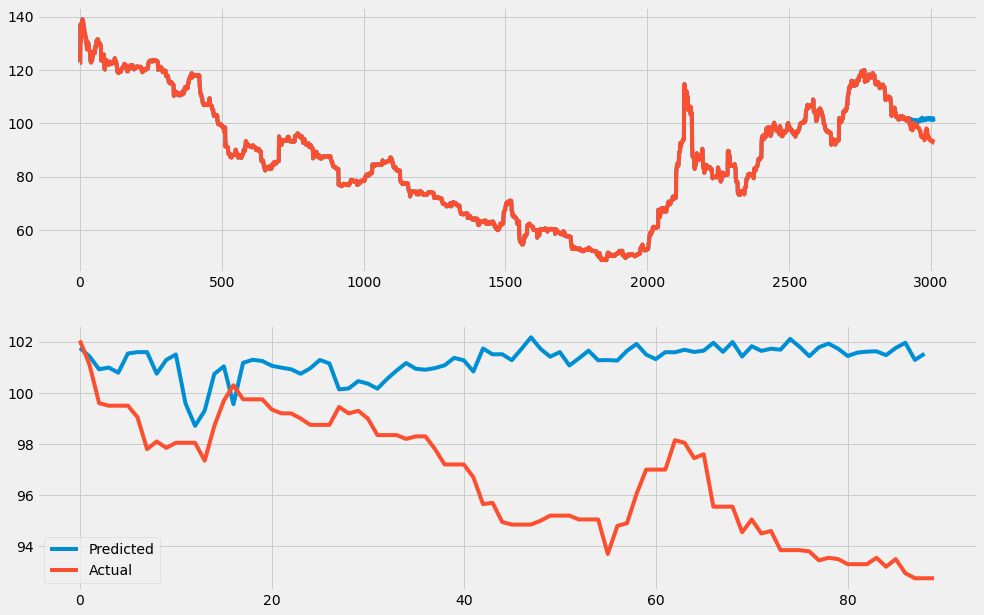

In [ ]:
plt.figure(figsize=(15,10))
plt.subplot(211)
plt.plot(df_drop['Coal_price'].values , label='Predicted')
plt.plot(df_coal['Coal_price'].values , label='Actual')


plt.subplot(212)
plt.plot(df_drop['Coal_price'][-90:].values, label='Predicted')
plt.plot(df_coal['Coal_price'][-90:].values, label='Actual')
plt.legend()
plt.show()

##2.5 recursive - 5days val

*   30개 변수 prophe prediction 값 
*   y_pred값을 validation셋에 추가


Data

*   df는 실제값으로 2018년도 12월 31일까지
*   df_pred는 prophet으로 prediction한 값 2019년부터 1월 1일까지 (Coal_price 제외)
*   df_merge에 예측에 필요한 coal_price값 제외하고 merge






In [ ]:
df = pd.read_excel("/content/gdrive/My Drive/Black_coal/data/dataset/project_dataset.xlsx")
df = df.sort_values('date')
df['date']= pd.to_datetime(df['date'])

df = df.set_index('date')
df = df[df.index < '2019-01-01']
df = df.reset_index()

In [ ]:
df_pred = pd.read_csv("/content/gdrive/My Drive/Black_coal/data/dataset/prophet_pred/prophet_pred_final.csv", encoding = 'utf-8-sig')
df_pred = df_pred.rename(columns ={'ds':'date'})
df_pred['date']= pd.to_datetime(df_pred['date'])

df_pred = df_pred.set_index('date')
df_pred = df_pred.reset_index()


In [ ]:
df_merge = pd.merge(df, df_pred, on=['date', 'Brent_fut', 'iron', 'copper_fut', 'WTI_fut', 'WTI', 'LNG_fut',
       'bdi', 'USD/AUD(호주)', 'USD/CAD(캐나다)', 'USD/COP(콜롬비아)', 'US 달러지수',
       'USD/IDR(인도네시아)', 'USD/RUB(러시아)', 'USD/ZAR(자메이카)', '상하이종합지수', '인도지수',
       '브라질지수', '다우존스지수', '프랑스지수', '영국지수', '독일지수', 'S&P500지수', '항셍지수', '나스닥지수',
       '코스피지수', '니케이225지수', '유로스톡스50지수', '호주지수', '캐나다지수'], how='outer')
       
df_merge = df_merge[['date', 'Coal_price', 'Brent_fut', 'iron', 'copper_fut', 'WTI_fut', 'WTI', 'LNG_fut',
       'bdi', 'USD/AUD(호주)', 'USD/CAD(캐나다)', 'USD/COP(콜롬비아)', 'US 달러지수',
       'USD/IDR(인도네시아)', 'USD/RUB(러시아)', 'USD/ZAR(자메이카)', '상하이종합지수', '인도지수',
       '브라질지수', '다우존스지수', '프랑스지수', '영국지수', '독일지수', 'S&P500지수', '항셍지수', '나스닥지수',
       '코스피지수', '니케이225지수', '유로스톡스50지수', '호주지수', '캐나다지수']]
df_merge['date']= pd.to_datetime(df_merge['date'])



In [ ]:
df_drop = df_merge.drop('date',axis=1)

In [ ]:
df_coal = pd.read_csv("/content/gdrive/My Drive/Black_coal/data/dataset/project_dataset.csv", encoding = 'utf-8-sig')
df_coal = df_coal.sort_values('date')
df_coal['date']= pd.to_datetime(df_coal['date'])

df_coal = df_coal.set_index('date')
df_coal = df_coal[df_coal.index < '2019-04-01']

df_coal = df_coal.reset_index()
df_coal = df_coal[['date','Coal_price']]


In [ ]:
df_merge = df_merge.set_index('date')

In [ ]:
for i in range (89):
    
  
  # 학습과 테스트 데이터 분리
  split =  len(df_merge[:"2018-12-25"])
  split1 =  len(df_merge[:"2018-12-31"])
  
  df_train = df_drop[:split+i]
  df_test = df_drop[split+i:split1+i]
  df_predict = df_drop[len(df_merge[:"2018-12-31"]):len(df_merge[:"2019-01-01"])]

  df_train_y = df_train.loc[:,'Coal_price']
  df_train_x = df_train.drop('Coal_price', axis=1)
  df_test_y = df_test.loc[:,'Coal_price']
  df_test_x = df_test.drop('Coal_price', axis=1)
  # 나중에 예측값과 비교하기 위해 test 데이터 복제본 저장
  df_test_orig = df_coal.loc[:, 'Coal_price']
  df_predict_x = df_predict.drop('Coal_price', axis=1)
  df_predict_x = df_predict_x[:]



  XG_model_month = xgb.XGBRegressor(learning_rate=0.1,max_depth=6,n_estimators=200)
  XG_model_month.fit(df_train_x, df_train_y, eval_set=[(df_test_x, df_test_y)], early_stopping_rounds=100,verbose=False)
  
  xgboost = XG_model_month.predict(df_predict_x)

  # 실제 값과 예측 값을 하나의 DataFrame으로 만들고 visualize
  result=pd.concat([df_test_orig.reset_index(), pd.DataFrame(xgboost, columns=['xgboost'])], axis=1, ignore_index=False)
  
  df_drop['Coal_price'][len(df_merge[:"2018-12-31"])+i]=result['xgboost'][0]
  # df_drop['shift'][len(df_merge[:"2019-01-01"])+i]=result['xgboost'][0]
  print(df_drop['Coal_price'][len(df_merge[:"2018-12-31"])]+i)
  # print(df_drop['shift'][len(df_merge[:"2019-01-01"])]+i)

[00:36:05] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
111.53956604003906
[00:36:07] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
112.53956604003906
[00:36:09] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
113.53956604003906
[00:36:11] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
114.53956604003906
[00:36:13] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
115.53956604003906
[00:36:15] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
116.53956604003906
[00:36:17] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederro

###result

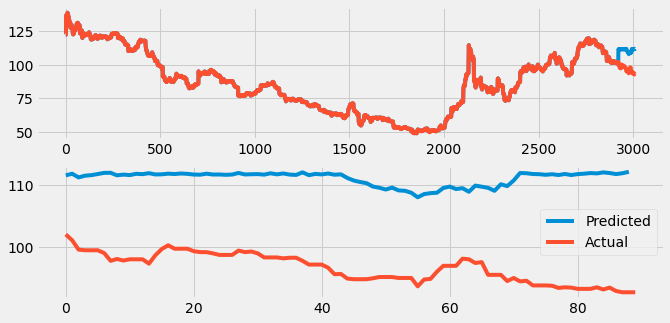

In [ ]:


plt.figure(figsize=(10,5))
plt.subplot(211)
plt.plot(df_drop['Coal_price'].values , label='Predicted')
plt.plot(df_coal['Coal_price'].values , label='Actual')

plt.subplot(212)
plt.plot(df_drop['Coal_price'][-90:].values, label='Predicted')
plt.plot(df_coal['Coal_price'][-90:].values, label='Actual')
plt.legend()
plt.show()

## 2.6 recursive - day val / t-1



*  t-1시점의 y데이터 추가
- recursive model






In [3]:
df2 = pd.read_excel("/content/gdrive/My Drive/Black_coal/data/dataset/project_dataset.xlsx")
df2 = df2.sort_values('date')
df2['date']= pd.to_datetime(df2['date'])

df2 = df2.set_index('date')
df2 = df2[df2.index < '2019-01-02']
df2 = df2.reset_index()
df2 = df2[['date','Coal_price']] 
df2 = df2.rename(columns ={'date':'ds'})
shift= df2['Coal_price'].shift(1)
shift[0]=df2['Coal_price'][0]

shift2 = df2[['ds','Coal_price']]
shift2=df2.rename(columns={'Coal_price' : 'shift'})
shift2['shift']=shift


df_merge=df_merge.reset_index()
df_merge=df_merge.rename(columns={'date':'ds'})
df_merge = pd.merge(df_merge,shift2,on='ds',how='outer')
df_drop = df_merge.drop('ds',axis=1)

In [4]:
df_merge=df_merge.set_index('ds')

In [5]:
for i in range (89):
    
  
  # 학습과 테스트 데이터 분리
  split =  len(df_merge[:"2018-12-30"])
  split1 =  len(df_merge[:"2018-12-31"])
  
  df_train = df_drop[:split+i]
  df_test = df_drop[split+i:split1+i]
  df_predict = df_drop[len(df_merge[:"2018-12-31"]):len(df_merge[:"2019-01-01"])]

  df_train_y = df_train.loc[:,'Coal_price']
  df_train_x = df_train.drop('Coal_price', axis=1)
  df_test_y = df_test.loc[:,'Coal_price']
  df_test_x = df_test.drop('Coal_price', axis=1)
  # 나중에 예측값과 비교하기 위해 test 데이터 복제본 저장
  df_test_orig = df_coal.loc[:, 'Coal_price']
  df_predict_x = df_predict.drop('Coal_price', axis=1)
  df_predict_x = df_predict_x[:]



  XG_model_month = xgb.XGBRegressor(learning_rate=0.1,max_depth=6,n_estimators=200)
  XG_model_month.fit(df_train_x, df_train_y, eval_set=[(df_test_x, df_test_y)], early_stopping_rounds=100,verbose=False)
  
  xgboost = XG_model_month.predict(df_predict_x)

  # 실제 값과 예측 값을 하나의 DataFrame으로 만들고 visualize
  result=pd.concat([df_test_orig.reset_index(), pd.DataFrame(xgboost, columns=['xgboost'])], axis=1, ignore_index=False)
  
  df_drop['Coal_price'][len(df_merge[:"2018-12-31"])+i]=result['xgboost'][0]
  df_drop['shift'][len(df_merge[:"2019-01-01"])+i]=result['xgboost'][0]
  print(df_drop['Coal_price'][len(df_merge[:"2018-12-31"])]+i)
  print(df_drop['shift'][len(df_merge[:"2019-01-01"])]+i)

[04:08:23] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
101.85194396972656
101.85194396972656
[04:08:25] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
102.85194396972656
102.85194396972656
[04:08:27] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
103.85194396972656
103.85194396972656
[04:08:29] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
104.85194396972656
104.85194396972656
[04:08:31] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
105.85194396972656
105.85194396972656
[04:08:33] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
106.85194396972656
106.85194396972656
[04:08:35]


###result

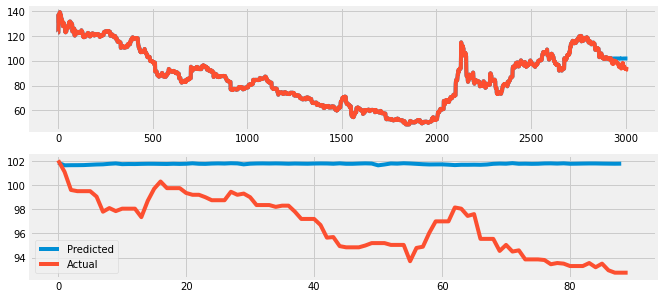

In [6]:
plt.figure(figsize=(10,5))
plt.subplot(211)
plt.plot(df_drop['Coal_price'].values , label='Predicted')
plt.plot(df_coal['Coal_price'].values , label='Actual')


plt.subplot(212)
plt.plot(df_drop['Coal_price'][-90:].values, label='Predicted')
plt.plot(df_coal['Coal_price'][-90:].values, label='Actual')
plt.legend()
plt.show()

##2.7 recursive - 1month val(변경)

*   30개 변수 prophe prediction 값 
*   y_pred값을 validation셋에 추가

*   결과값이 좀 보여서 다른 기간내에 적용해보기




Data

*   df는 실제값으로 2018년도 12월 31일까지
*   df_pred는 prophet으로 prediction한 값 2019년부터 1월 1일까지 (Coal_price 제외)
*   df_merge에 예측에 필요한 coal_price값 제외하고 merge






In [7]:
df = pd.read_excel("/content/gdrive/My Drive/Black_coal/data/dataset/project_dataset.xlsx")
df = df.sort_values('date')
df['date']= pd.to_datetime(df['date'])

df = df.set_index('date')
df = df[df.index < '2019-01-01']
df = df.reset_index()

In [8]:
df_pred = pd.read_csv("/content/gdrive/My Drive/Black_coal/data/dataset/prophet_pred/prophet_pred_final.csv", encoding = 'utf-8-sig')
df_pred = df_pred.rename(columns ={'ds':'date'})
df_pred['date']= pd.to_datetime(df_pred['date'])

df_pred = df_pred.set_index('date')
df_pred = df_pred.reset_index()


In [9]:
df_merge = pd.merge(df, df_pred, on=['date', 'Brent_fut', 'iron', 'copper_fut', 'WTI_fut', 'WTI', 'LNG_fut',
       'bdi', 'USD/AUD(호주)', 'USD/CAD(캐나다)', 'USD/COP(콜롬비아)', 'US 달러지수',
       'USD/IDR(인도네시아)', 'USD/RUB(러시아)', 'USD/ZAR(자메이카)', '상하이종합지수', '인도지수',
       '브라질지수', '다우존스지수', '프랑스지수', '영국지수', '독일지수', 'S&P500지수', '항셍지수', '나스닥지수',
       '코스피지수', '니케이225지수', '유로스톡스50지수', '호주지수', '캐나다지수'], how='outer')
       
df_merge = df_merge[['date', 'Coal_price', 'Brent_fut', 'iron', 'copper_fut', 'WTI_fut', 'WTI', 'LNG_fut',
       'bdi', 'USD/AUD(호주)', 'USD/CAD(캐나다)', 'USD/COP(콜롬비아)', 'US 달러지수',
       'USD/IDR(인도네시아)', 'USD/RUB(러시아)', 'USD/ZAR(자메이카)', '상하이종합지수', '인도지수',
       '브라질지수', '다우존스지수', '프랑스지수', '영국지수', '독일지수', 'S&P500지수', '항셍지수', '나스닥지수',
       '코스피지수', '니케이225지수', '유로스톡스50지수', '호주지수', '캐나다지수']]
df_merge['date']= pd.to_datetime(df_merge['date'])



In [10]:
df_drop = df_merge.drop('date',axis=1)


In [11]:
df_coal = pd.read_csv("/content/gdrive/My Drive/Black_coal/data/dataset/project_dataset.csv", encoding = 'utf-8-sig')
df_coal = df_coal.sort_values('date')
df_coal['date']= pd.to_datetime(df_coal['date'])

df_coal = df_coal.set_index('date')
df_coal = df_coal[df_coal.index < '2019-04-01']

df_coal = df_coal.reset_index()
df_coal = df_coal[['date','Coal_price']]


In [12]:
df_merge = df_merge.set_index('date')

In [13]:
for i in range (89):
    
  
  # 학습과 테스트 데이터 분리
  split =  len(df_merge[:"2018-11-30"])
  split1 =  len(df_merge[:"2018-12-31"])
  
  df_train = df_drop[:split+i]
  df_test = df_drop[split+i:split1+i]
  df_predict = df_drop[len(df_merge[:"2018-12-31"]):len(df_merge[:"2019-01-01"])]

  df_train_y = df_train.loc[:,'Coal_price']
  df_train_x = df_train.drop('Coal_price', axis=1)
  df_test_y = df_test.loc[:,'Coal_price']
  df_test_x = df_test.drop('Coal_price', axis=1)
  # 나중에 예측값과 비교하기 위해 test 데이터 복제본 저장
  df_test_orig = df_coal.loc[:, 'Coal_price']
  df_predict_x = df_predict.drop('Coal_price', axis=1)
  df_predict_x = df_predict_x[:]



  XG_model_month = xgb.XGBRegressor(num_round=100,learning_rate=0.6,max_depth=5,n_estimators=30)
  XG_model_month.fit(df_train_x, df_train_y, 
                     #eval_set=[(df_test_x, df_test_y)], early_stopping_rounds=100,
                     verbose=False)
  
  xgboost = XG_model_month.predict(df_predict_x)

  # 실제 값과 예측 값을 하나의 DataFrame으로 만들고 visualize
  result=pd.concat([df_test_orig.reset_index(), pd.DataFrame(xgboost, columns=['xgboost'])], axis=1, ignore_index=False)
  
  df_drop['Coal_price'][len(df_merge[:"2018-12-31"])+i]=result['xgboost'][0]
  # df_drop['shift'][len(df_merge[:"2019-01-01"])+i]=result['xgboost'][0]
  print(df_drop['Coal_price'][len(df_merge[:"2018-12-31"])]+i)
  # print(df_drop['shift'][len(df_merge[:"2019-01-01"])]+i)

[04:12:35] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
111.6798324584961
[04:12:35] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
112.6798324584961
[04:12:35] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
113.6798324584961
[04:12:36] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
114.6798324584961
[04:12:36] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
115.6798324584961
[04:12:36] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
116.6798324584961
[04:12:37] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
117

###result

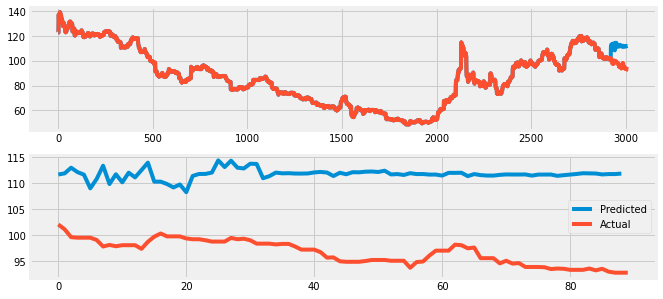

In [15]:
plt.figure(figsize=(10,5))
plt.subplot(211)
plt.plot(df_drop['Coal_price'].values , label='Predicted')
plt.plot(df_coal['Coal_price'].values , label='Actual')

plt.subplot(212)
plt.plot(df_drop['Coal_price'][-90:].values, label='Predicted')
plt.plot(df_coal['Coal_price'][-90:].values, label='Actual')
plt.legend()
plt.show()
























































































































































































































## 2.8 recursive - 1month val / t-1



*  t-1시점의 y데이터 추가
- recursive model






In [16]:
df2 = pd.read_excel("/content/gdrive/My Drive/Black_coal/data/dataset/project_dataset.xlsx")
df2 = df2.sort_values('date')
df2['date']= pd.to_datetime(df2['date'])

df2 = df2.set_index('date')
df2 = df2[df2.index < '2019-01-02']
df2 = df2.reset_index()
df2 = df2[['date','Coal_price']] 
df2 = df2.rename(columns ={'date':'ds'})
shift= df2['Coal_price'].shift(1)
shift[0]=df2['Coal_price'][0]

shift2 = df2[['ds','Coal_price']]
shift2=df2.rename(columns={'Coal_price' : 'shift'})
shift2['shift']=shift


df_merge=df_merge.reset_index()
df_merge=df_merge.rename(columns={'date':'ds'})
df_merge = pd.merge(df_merge,shift2,on='ds',how='outer')
df_drop = df_merge.drop('ds',axis=1)

In [17]:
df_merge=df_merge.set_index('ds')

In [18]:
for i in range (89):
    
  
  # 학습과 테스트 데이터 분리
  split =  len(df_merge[:"2018-11-30"])
  split1 =  len(df_merge[:"2018-12-31"])
  
  df_train = df_drop[:split+i]
  df_test = df_drop[split+i:split1+i]
  df_predict = df_drop[len(df_merge[:"2018-12-31"]):len(df_merge[:"2019-01-01"])]

  df_train_y = df_train.loc[:,'Coal_price']
  df_train_x = df_train.drop('Coal_price', axis=1)
  df_test_y = df_test.loc[:,'Coal_price']
  df_test_x = df_test.drop('Coal_price', axis=1)
  # 나중에 예측값과 비교하기 위해 test 데이터 복제본 저장
  df_test_orig = df_coal.loc[:, 'Coal_price']
  df_predict_x = df_predict.drop('Coal_price', axis=1)
  df_predict_x = df_predict_x[:]



  XG_model_month = xgb.XGBRegressor(learning_rate=0.1,max_depth=6,n_estimators=200)
  XG_model_month.fit(df_train_x, df_train_y, eval_set=[(df_test_x, df_test_y)], early_stopping_rounds=100,verbose=False)
  
  xgboost = XG_model_month.predict(df_predict_x)

  # 실제 값과 예측 값을 하나의 DataFrame으로 만들고 visualize
  result=pd.concat([df_test_orig.reset_index(), pd.DataFrame(xgboost, columns=['xgboost'])], axis=1, ignore_index=False)
  
  df_drop['Coal_price'][len(df_merge[:"2018-12-31"])+i]=result['xgboost'][0]
  df_drop['shift'][len(df_merge[:"2019-01-01"])+i]=result['xgboost'][0]
  print(df_drop['Coal_price'][len(df_merge[:"2018-12-31"])]+i)
  print(df_drop['shift'][len(df_merge[:"2019-01-01"])]+i)

[04:16:25] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
101.59574127197266
101.59574127197266
[04:16:28] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
102.59574127197266
102.59574127197266
[04:16:30] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
103.59574127197266
103.59574127197266
[04:16:32] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
104.59574127197266
104.59574127197266
[04:16:34] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
105.59574127197266
105.59574127197266
[04:16:36] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
106.59574127197266
106.59574127197266
[04:16:39]

###result

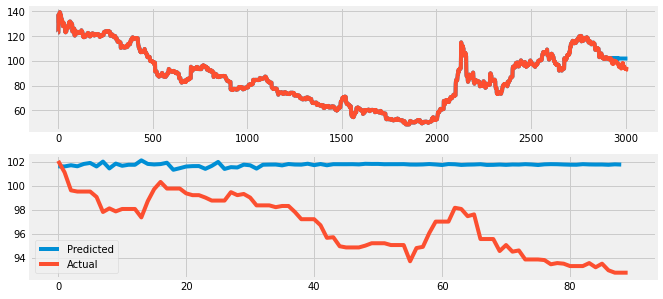

In [20]:
plt.figure(figsize=(10,5))
plt.subplot(211)
plt.plot(df_drop['Coal_price'].values , label='Predicted')
plt.plot(df_coal['Coal_price'].values , label='Actual')


plt.subplot(212)
plt.plot(df_drop['Coal_price'][-90:].values, label='Predicted')
plt.plot(df_coal['Coal_price'][-90:].values, label='Actual')
plt.legend()
plt.show()

##2.9 recursive (1년 val- test기간 맞추기)

*   30개 변수 prophe prediction 값 
*   y_pred값을 validation셋에 추가


In [ ]:
df_merge = df_merge.set_index('date')

In [22]:
for i in range (89):
    
  
  # 학습과 테스트 데이터 분리
  split =  len(df_merge[:"2018-12-31"])
  split1 =  len(df_merge[:"2018-12-31"])
  
  df_train = df_drop[:split+i]
  df_test = df_drop[split+i:split1+i]
  df_predict = df_drop[len(df_merge[:"2018-12-31"]):len(df_merge[:"2019-01-01"])]

  df_train_y = df_train.loc[:,'Coal_price']
  df_train_x = df_train.drop('Coal_price', axis=1)
  df_test_y = df_test.loc[:,'Coal_price']
  df_test_x = df_test.drop('Coal_price', axis=1)
  # 나중에 예측값과 비교하기 위해 test 데이터 복제본 저장
  df_test_orig = df_coal.loc[:, 'Coal_price']
  df_predict_x = df_predict.drop('Coal_price', axis=1)
  df_predict_x = df_predict_x[:]



  XG_model_month = xgb.XGBRegressor(learning_rate=0.1,max_depth=6,n_estimators=200)
  XG_model_month.fit(df_train_x, df_train_y)
  # XG_model_month.fit(df_train_x, df_train_y, eval_set=[(df_test_x, df_test_y)], early_stopping_rounds=100,verbose=False)
  
  xgboost = XG_model_month.predict(df_predict_x)

  # 실제 값과 예측 값을 하나의 DataFrame으로 만들고 visualize
  result=pd.concat([df_test_orig.reset_index(), pd.DataFrame(xgboost, columns=['xgboost'])], axis=1, ignore_index=False)
  
  df_drop['Coal_price'][len(df_merge[:"2018-12-31"])+i]=result['xgboost'][0]
  # df_drop['shift'][len(df_merge[:"2019-01-01"])+i]=result['xgboost'][0]
  print(df_drop['Coal_price'][len(df_merge[:"2018-12-31"])]+i)
  # print(df_drop['shift'][len(df_merge[:"2019-01-01"])]+i)

[04:42:09] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
101.39905548095703
[04:42:12] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
102.39905548095703
[04:42:15] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
103.39905548095703
[04:42:18] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
104.39905548095703
[04:42:20] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
105.39905548095703
[04:42:22] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
106.39905548095703
[04:42:24] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederro

###result

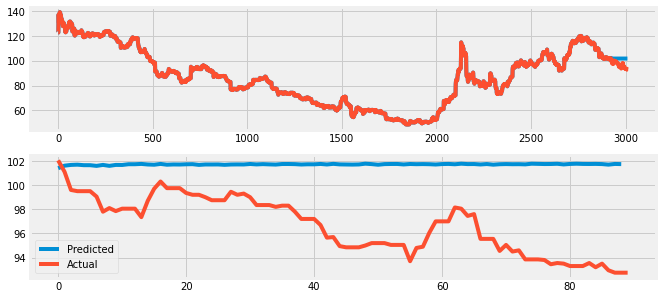

In [23]:
plt.figure(figsize=(10,5))
plt.subplot(211)
plt.plot(df_drop['Coal_price'].values , label='Predicted')
plt.plot(df_coal['Coal_price'].values , label='Actual')


plt.subplot(212)
plt.plot(df_drop['Coal_price'][-90:].values, label='Predicted')
plt.plot(df_coal['Coal_price'][-90:].values, label='Actual')
plt.legend()
plt.show()

##2.10 recursive / (t-1Coal_price)



*  t-1시점의 y데이터 추가
- recursive model






In [24]:
df2 = pd.read_excel("/content/gdrive/My Drive/Black_coal/data/dataset/project_dataset.xlsx")
df2 = df2.sort_values('date')
df2['date']= pd.to_datetime(df2['date'])

df2 = df2.set_index('date')
df2 = df2[df2.index < '2019-01-02']
df2 = df2.reset_index()
df2 = df2[['date','Coal_price']] 
df2 = df2.rename(columns ={'date':'ds'})
shift= df2['Coal_price'].shift(1)
shift[0]=df2['Coal_price'][0]

shift2 = df2[['ds','Coal_price']]
shift2=df2.rename(columns={'Coal_price' : 'shift'})
shift2['shift']=shift
shift2



,ds,shift
0,2011-01-01,122.65
1,2011-01-02,122.65
2,2011-01-03,122.65
3,2011-01-04,136.50
4,2011-01-05,137.30
...,...,...
2918,2018-12-28,101.55
2919,2018-12-29,101.90
2920,2018-12-30,101.90
2921,2018-12-31,101.90


In [25]:
df_merge=df_merge.reset_index()

In [26]:
df_merge=df_merge.rename(columns={'date':'ds'})
df_merge

,ds,Coal_price,Brent_fut,iron,copper_fut,WTI_fut,WTI,LNG_fut,bdi,USD/AUD(호주),...,독일지수,S&P500지수,항셍지수,나스닥지수,코스피지수,니케이225지수,유로스톡스50지수,호주지수,캐나다지수,shift
0,2011-01-01,122.65,94.750000,168.300000,9644.000000,91.380000,91.400000,61.070000,1773.000000,0.984470,...,6914.189941,1257.640015,23035.449219,2652.870117,2051.000000,10228.919922,2807.040039,4745.200195,13443.200195,122.65
1,2011-01-02,122.65,94.750000,168.300000,9644.000000,91.380000,91.400000,61.070000,1773.000000,0.984470,...,6914.189941,1257.640015,23035.449219,2652.870117,2051.000000,10228.919922,2807.040039,4745.200195,13443.200195,122.65
2,2011-01-03,136.50,94.840000,170.000000,9644.000000,91.550000,91.560000,61.070000,1773.000000,0.979010,...,6989.740234,1271.869995,23436.050781,2691.520020,2070.080078,10228.919922,2839.429932,4745.200195,13443.200195,122.65
3,2011-01-04,137.30,93.530000,172.100000,9619.250000,89.380000,89.230000,58.320000,1693.000000,0.983370,...,6975.350098,1270.199951,23668.480469,2681.250000,2085.139893,10398.099609,2844.169922,4742.500000,13402.299805,136.50
4,2011-01-05,130.65,95.500000,174.500000,9586.000000,90.300000,90.380000,56.400000,1621.000000,0.992850,...,6939.819824,1276.560059,23757.820312,2702.199951,2082.550049,10380.769531,2833.739990,4714.899902,13396.000000,137.30
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3007,2019-03-27,NaN,84.124730,72.446181,6703.428741,74.566090,74.733597,71.442419,1402.027680,1.372171,...,11897.295010,2918.493060,29237.210404,8123.580208,2252.528334,23546.358166,3263.093898,6171.147374,15954.943396,NaN
3008,2019-03-28,NaN,84.199753,72.354536,6691.270487,74.562116,74.750119,71.307777,1399.854283,1.373349,...,11893.885654,2919.238593,29209.282776,8123.496620,2252.020118,23542.239644,3261.886242,6175.229169,15943.334716,NaN
3009,2019-03-29,NaN,84.291781,72.370737,6683.270496,74.628844,74.817677,71.206234,1396.475330,1.374941,...,11888.538235,2919.920821,29195.805869,8122.842283,2249.926048,23541.187552,3259.948145,6176.074040,15927.833254,NaN
3010,2019-03-30,NaN,84.363165,72.375087,6673.171699,74.731828,74.938001,71.049927,1390.815421,1.376403,...,11884.435037,2920.547457,29173.373865,8122.769151,2247.524109,23537.235686,3257.373048,6176.594855,15915.512454,NaN


In [27]:
df_merge = pd.merge(df_merge,shift2,on='ds',how='outer')
df_merge

,ds,Coal_price,Brent_fut,iron,copper_fut,WTI_fut,WTI,LNG_fut,bdi,USD/AUD(호주),...,S&P500지수,항셍지수,나스닥지수,코스피지수,니케이225지수,유로스톡스50지수,호주지수,캐나다지수,shift_x,shift_y
0,2011-01-01,122.65,94.750000,168.300000,9644.000000,91.380000,91.400000,61.070000,1773.000000,0.984470,...,1257.640015,23035.449219,2652.870117,2051.000000,10228.919922,2807.040039,4745.200195,13443.200195,122.65,122.65
1,2011-01-02,122.65,94.750000,168.300000,9644.000000,91.380000,91.400000,61.070000,1773.000000,0.984470,...,1257.640015,23035.449219,2652.870117,2051.000000,10228.919922,2807.040039,4745.200195,13443.200195,122.65,122.65
2,2011-01-03,136.50,94.840000,170.000000,9644.000000,91.550000,91.560000,61.070000,1773.000000,0.979010,...,1271.869995,23436.050781,2691.520020,2070.080078,10228.919922,2839.429932,4745.200195,13443.200195,122.65,122.65
3,2011-01-04,137.30,93.530000,172.100000,9619.250000,89.380000,89.230000,58.320000,1693.000000,0.983370,...,1270.199951,23668.480469,2681.250000,2085.139893,10398.099609,2844.169922,4742.500000,13402.299805,136.50,136.50
4,2011-01-05,130.65,95.500000,174.500000,9586.000000,90.300000,90.380000,56.400000,1621.000000,0.992850,...,1276.560059,23757.820312,2702.199951,2082.550049,10380.769531,2833.739990,4714.899902,13396.000000,137.30,137.30
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3007,2019-03-27,NaN,84.124730,72.446181,6703.428741,74.566090,74.733597,71.442419,1402.027680,1.372171,...,2918.493060,29237.210404,8123.580208,2252.528334,23546.358166,3263.093898,6171.147374,15954.943396,NaN,NaN
3008,2019-03-28,NaN,84.199753,72.354536,6691.270487,74.562116,74.750119,71.307777,1399.854283,1.373349,...,2919.238593,29209.282776,8123.496620,2252.020118,23542.239644,3261.886242,6175.229169,15943.334716,NaN,NaN
3009,2019-03-29,NaN,84.291781,72.370737,6683.270496,74.628844,74.817677,71.206234,1396.475330,1.374941,...,2919.920821,29195.805869,8122.842283,2249.926048,23541.187552,3259.948145,6176.074040,15927.833254,NaN,NaN
3010,2019-03-30,NaN,84.363165,72.375087,6673.171699,74.731828,74.938001,71.049927,1390.815421,1.376403,...,2920.547457,29173.373865,8122.769151,2247.524109,23537.235686,3257.373048,6176.594855,15915.512454,NaN,NaN


In [28]:
df_drop = df_merge.drop('ds',axis=1)

In [29]:
df_merge=df_merge.set_index('ds')

In [30]:
for i in range (89):
    
  
  # 학습과 테스트 데이터 분리
  split =  len(df_merge[:"2018-12-31"])
  split1 =  len(df_merge[:"2018-12-31"])
  
  df_train = df_drop[:split+i]
  df_test = df_drop[split+i:split1+i]
  df_predict = df_drop[len(df_merge[:"2018-12-31"]):len(df_merge[:"2019-01-01"])]

  df_train_y = df_train.loc[:,'Coal_price']
  df_train_x = df_train.drop('Coal_price', axis=1)
  df_test_y = df_test.loc[:,'Coal_price']
  df_test_x = df_test.drop('Coal_price', axis=1)
  # 나중에 예측값과 비교하기 위해 test 데이터 복제본 저장
  df_test_orig = df_coal.loc[:, 'Coal_price']
  df_predict_x = df_predict.drop('Coal_price', axis=1)
  df_predict_x = df_predict_x[:]



  XG_model_month = xgb.XGBRegressor(learning_rate=0.1,max_depth=6,n_estimators=200)
  XG_model_month.fit(df_train_x, df_train_y)
  
  xgboost = XG_model_month.predict(df_predict_x)

  # 실제 값과 예측 값을 하나의 DataFrame으로 만들고 visualize
  result=pd.concat([df_test_orig.reset_index(), pd.DataFrame(xgboost, columns=['xgboost'])], axis=1, ignore_index=False)
  
  df_drop['Coal_price'][len(df_merge[:"2018-12-31"])+i]=result['xgboost'][0]
  df_drop['shift'][len(df_merge[:"2019-01-01"])+i]=result['xgboost'][0]
  print(df_drop['Coal_price'][len(df_merge[:"2018-12-31"])]+i)
  print(df_drop['shift'][len(df_merge[:"2019-01-01"])]+i)

[04:45:56] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


KeyError: ignored

###result

In [ ]:
plt.figure(figsize=(10,5))
plt.subplot(211)
plt.plot(df_drop['Coal_price'].values , label='Predicted')
plt.plot(df_coal['Coal_price'].values , label='Actual')


plt.subplot(212)
plt.plot(df_drop['Coal_price'][-90:].values, label='Predicted')
plt.plot(df_coal['Coal_price'][-90:].values, label='Actual')
plt.legend()
plt.show()

#3.(prophet+xgboost)

*   df는 실제값으로 2018년도 12월 31일까지
*   df_pred는 prophet으로 prediction한 값 2019년부터 1월 1일까지 (Coal_price 제외)







In [31]:
df = pd.read_excel("/content/gdrive/My Drive/Black_coal/data/dataset/project_dataset.xlsx")
df = df.sort_values('date')
df['date']= pd.to_datetime(df['date'])

df = df.set_index('date')
df = df[df.index < '2019-01-01']
df = df.reset_index()
df_pred = pd.read_csv("/content/gdrive/My Drive/Black_coal/data/dataset/prophet_pred/prophet_pred_final.csv", encoding = 'utf-8-sig')
df_pred = df_pred.rename(columns ={'ds':'date'})
df_pred['date']= pd.to_datetime(df_pred['date'])

df_pred = df_pred.set_index('date')
df_pred = df_pred.reset_index()
df_merge = pd.merge(df, df_pred, on=['date', 'Brent_fut', 'iron', 'copper_fut', 'WTI_fut', 'WTI', 'LNG_fut',
       'bdi', 'USD/AUD(호주)', 'USD/CAD(캐나다)', 'USD/COP(콜롬비아)', 'US 달러지수',
       'USD/IDR(인도네시아)', 'USD/RUB(러시아)', 'USD/ZAR(자메이카)', '상하이종합지수', '인도지수',
       '브라질지수', '다우존스지수', '프랑스지수', '영국지수', '독일지수', 'S&P500지수', '항셍지수', '나스닥지수',
       '코스피지수', '니케이225지수', '유로스톡스50지수', '호주지수', '캐나다지수'], how='outer')
       
df_merge = df_merge[['date', 'Coal_price', 'Brent_fut', 'iron', 'copper_fut', 'WTI_fut', 'WTI', 'LNG_fut',
       'bdi', 'USD/AUD(호주)', 'USD/CAD(캐나다)', 'USD/COP(콜롬비아)', 'US 달러지수',
       'USD/IDR(인도네시아)', 'USD/RUB(러시아)', 'USD/ZAR(자메이카)', '상하이종합지수', '인도지수',
       '브라질지수', '다우존스지수', '프랑스지수', '영국지수', '독일지수', 'S&P500지수', '항셍지수', '나스닥지수',
       '코스피지수', '니케이225지수', '유로스톡스50지수', '호주지수', '캐나다지수']]
df_merge['date']= pd.to_datetime(df_merge['date'])
df_coal = pd.read_csv("/content/gdrive/My Drive/Black_coal/data/dataset/project_dataset.csv", encoding = 'utf-8-sig')
df_coal = df_coal.sort_values('date')
df_coal['date']= pd.to_datetime(df_coal['date'])

df_coal = df_coal.set_index('date')
df_coal = df_coal[df_coal.index < '2019-04-01']


df_coal = df_coal.reset_index()
df_coal = df_coal[['date','Coal_price']]
df_merge=df_merge.set_index('date')

In [32]:

# 학습과 테스트 데이터 분리
split =  "2018-12-10"
split1 =  "2018-12-31"

df_train = df_merge[:split]
df_test = df_merge[split:split1]
df_predict = df_merge["2019-01-01":"2019-03-31"]

df_train_y = df_train.loc[:,'Coal_price']
df_train_x = df_train.drop('Coal_price', axis=1)
df_test_y = df_test.loc[:,'Coal_price']
df_test_x = df_test.drop('Coal_price', axis=1)
# 나중에 예측값과 비교하기 위해 test 데이터 복제본 저장
df_test_orig = df_coal.loc[:, 'Coal_price']
df_predict_x = df_predict.drop('Coal_price', axis=1)
df_predict_x = df_predict_x[:]


[04:46:30] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


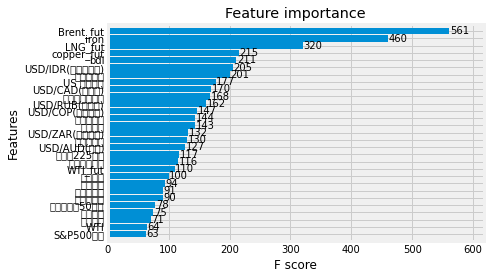

In [33]:
XG_model_month = xgb.XGBRegressor(learning_rate=0.1,max_depth=6,n_estimators=200)
XG_model_month.fit(df_train_x, df_train_y, eval_set=[(df_test_x, df_test_y)], early_stopping_rounds=100,verbose=False)

# 주요하게 적용하는 변수를 판단
plot_importance(XG_model_month, height=0.9)

###result

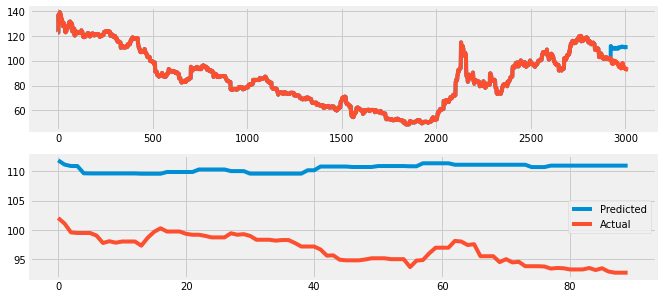

In [34]:
# 테스트 데이터 중 특정 store/item 데이터를 추출


xgboost = XG_model_month.predict(df_predict_x)

# 실제 값과 예측 값을 하나의 DataFrame으로 만들고 visualize
result=pd.concat([df_test_orig.reset_index(), pd.DataFrame(xgboost, columns=['xgboost'])], axis=1, ignore_index=False)
# result = result.set_index('date')
result = result.loc[:, ['Coal_price', 'xgboost']]

df_con=pd.concat([df_train['Coal_price'],df_test['Coal_price']],axis=0)
df_con=pd.concat([df_con,result['xgboost']],axis=0)
con = pd.DataFrame(df_con)


plt.figure(figsize=(10,5))
plt.subplot(211)
plt.plot(con.values , label='Predicted')
plt.plot(df_coal['Coal_price'].values , label='Actual')


plt.subplot(212)
plt.plot(result['xgboost'].values, label='Predicted')
plt.plot(df_coal['Coal_price'][-90:].values, label='Actual')
plt.legend()
plt.show()

Max_depth 20

[04:46:32] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


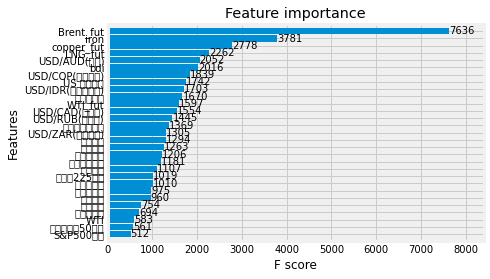

In [35]:
XG_model_month = xgb.XGBRegressor(n_estimators=1000, max_depth= 20)
XG_model_month.fit(df_train_x, df_train_y, eval_set=[(df_test_x, df_test_y)], early_stopping_rounds=100,verbose=False)

# 주요하게 적용하는 변수를 판단
plot_importance(XG_model_month, height=0.9)

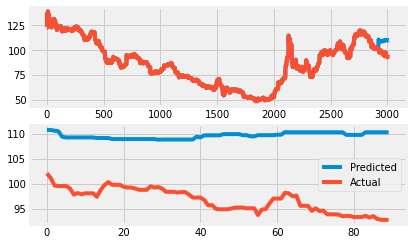

In [36]:
# 테스트 데이터 중 특정 store/item 데이터를 추출


xgboost = XG_model_month.predict(df_predict_x)

# 실제 값과 예측 값을 하나의 DataFrame으로 만들고 visualize
result=pd.concat([df_test_orig.reset_index(), pd.DataFrame(xgboost, columns=['xgboost'])], axis=1, ignore_index=False)
# result = result.set_index('date')
result = result.loc[:, ['Coal_price', 'xgboost']]

df_con=pd.concat([df_train['Coal_price'],df_test['Coal_price']],axis=0)
df_con=pd.concat([df_con,result['xgboost']],axis=0)
con = pd.DataFrame(df_con)

plt.subplot(211)
plt.plot(con.values , label='Predicted')
plt.plot(df_coal['Coal_price'].values , label='Actual')


plt.subplot(212)
plt.plot(result['xgboost'].values, label='Predicted')
plt.plot(df_coal['Coal_price'][-90:].values, label='Actual')
plt.legend()
plt.show()

Max_depth 30

[04:46:38] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


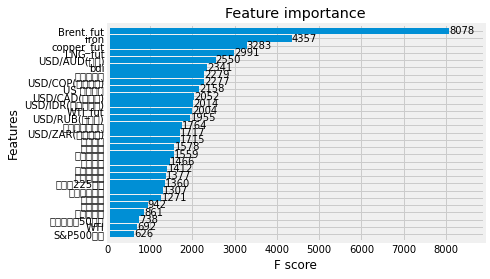

In [37]:
XG_model_month = xgb.XGBRegressor(n_estimators=1000, max_depth= 30)
XG_model_month.fit(df_train_x, df_train_y, eval_set=[(df_test_x, df_test_y)], early_stopping_rounds=100,verbose=False)

# 주요하게 적용하는 변수를 판단
plot_importance(XG_model_month, height=0.9)

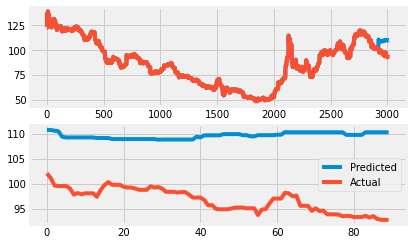

In [38]:
# 테스트 데이터 중 특정 store/item 데이터를 추출


xgboost = XG_model_month.predict(df_predict_x)

# 실제 값과 예측 값을 하나의 DataFrame으로 만들고 visualize
result=pd.concat([df_test_orig.reset_index(), pd.DataFrame(xgboost, columns=['xgboost'])], axis=1, ignore_index=False)
# result = result.set_index('date')
result = result.loc[:, ['Coal_price', 'xgboost']]

df_con=pd.concat([df_train['Coal_price'],df_test['Coal_price']],axis=0)
df_con=pd.concat([df_con,result['xgboost']],axis=0)
con = pd.DataFrame(df_con)

plt.subplot(211)
plt.plot(con.values , label='Predicted')
plt.plot(df_coal['Coal_price'].values , label='Actual')


plt.subplot(212)
plt.plot(result['xgboost'].values, label='Predicted')
plt.plot(df_coal['Coal_price'][-90:].values, label='Actual')
plt.legend()
plt.show()

#4.(feature true 값- xgboost)

*   df는 실제값으로 2018년도 12월 31일까지
*   df_pred는 prophet으로 prediction한 값 2019년부터 1월 1일까지 (Coal_price 제외)







In [39]:
df = pd.read_excel("/content/gdrive/My Drive/Black_coal/data/dataset/project_dataset.xlsx")
df = df.sort_values('date')
df['date']= pd.to_datetime(df['date'])

df = df.set_index('date')
df = df[df.index < '2019-04-01']
df = df.reset_index()
df = df.drop('Coal_price',axis=1)

df_coal = pd.read_csv("/content/gdrive/My Drive/Black_coal/data/dataset/project_dataset.csv", encoding = 'utf-8-sig')
df_coal = df_coal.sort_values('date')
df_coal['date']= pd.to_datetime(df_coal['date'])

df_coal = df_coal.set_index('date')
df_coal = df_coal[df_coal.index <'2019-01-01']

df_coal = df_coal.reset_index()
df_coal = df_coal[['date','Coal_price']]

In [40]:
df_merge=pd.merge(df_coal,df, how='right')
df_merge

,date,Coal_price,iron,Brent_fut,copper_fut,WTI_fut,WTI,LNG_fut,bdi,USD/AUD(호주),...,영국지수,독일지수,S&P500지수,항셍지수,나스닥지수,코스피지수,니케이225지수,유로스톡스50지수,호주지수,캐나다지수
0,2011-01-01,122.65,168.30,94.75,9644.00,91.38,91.40,61.07,1773.0,0.98447,...,5899.899902,6914.189941,1257.640015,23035.449219,2652.870117,2051.000000,10228.919922,2807.040039,4745.200195,13443.200195
1,2011-01-02,122.65,168.30,94.75,9644.00,91.38,91.40,61.07,1773.0,0.98447,...,5899.899902,6914.189941,1257.640015,23035.449219,2652.870117,2051.000000,10228.919922,2807.040039,4745.200195,13443.200195
2,2011-01-03,136.50,170.00,94.84,9644.00,91.55,91.56,61.07,1773.0,0.97901,...,5899.899902,6989.740234,1271.869995,23436.050781,2691.520020,2070.080078,10228.919922,2839.429932,4745.200195,13443.200195
3,2011-01-04,137.30,172.10,93.53,9619.25,89.38,89.23,58.32,1693.0,0.98337,...,6013.899902,6975.350098,1270.199951,23668.480469,2681.250000,2085.139893,10398.099609,2844.169922,4742.500000,13402.299805
4,2011-01-05,130.65,174.50,95.50,9586.00,90.30,90.38,56.40,1621.0,0.99285,...,6043.899902,6939.819824,1276.560059,23757.820312,2702.199951,2082.550049,10380.769531,2833.739990,4714.899902,13396.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3007,2019-03-27,NaN,85.72,67.83,6336.00,59.41,59.12,37.47,690.0,1.40115,...,7194.200195,11419.040039,2805.370117,28728.250000,7643.379883,2145.620117,21378.730469,3322.040039,6136.000000,16132.500000
3008,2019-03-28,NaN,85.64,67.82,6368.75,59.30,59.30,36.05,692.0,1.41153,...,7234.299805,11428.160156,2815.439941,28775.210938,7669.169922,2128.100098,21033.759766,3320.290039,6176.100098,16155.500000
3009,2019-03-29,NaN,85.70,68.39,6475.75,60.14,59.98,34.61,689.0,1.41180,...,7279.200195,11526.040039,2834.399902,29051.359375,7729.319824,2140.669922,21205.810547,3351.709961,6180.700195,16102.099609
3010,2019-03-30,NaN,85.70,68.39,6475.75,60.14,59.98,34.61,689.0,1.41180,...,7279.200195,11526.040039,2834.399902,29051.359375,7729.319824,2140.669922,21205.810547,3351.709961,6180.700195,16102.099609


In [41]:
df_merge=df_merge.set_index('date')

In [42]:
split =  "2018-12-31"
split1 =  "2019-04-01"

df_merge[split:split1]

,Coal_price,iron,Brent_fut,copper_fut,WTI_fut,WTI,LNG_fut,bdi,USD/AUD(호주),USD/CAD(캐나다),...,영국지수,독일지수,S&P500지수,항셍지수,나스닥지수,코스피지수,니케이225지수,유로스톡스50지수,호주지수,캐나다지수
date,,,,,,,,,,,,,,,,,,,,,
2018-12-31,102.05,69.20,53.80,5981.00,45.41,45.00,61.07,1271.0,1.41950,1.36220,...,6728.100098,10558.959961,2506.850098,25845.699219,6635.279785,2041.040039,20014.769531,2986.530029,5646.399902,14322.900391
2019-01-01,NaN,69.20,53.80,5981.00,45.89,45.00,61.07,1271.0,1.42010,1.33943,...,6728.100098,10558.959961,2506.850098,25845.699219,6635.279785,2041.040039,20014.769531,2986.530029,5646.399902,14322.900391
2019-01-02,NaN,71.06,54.91,5871.25,46.54,45.66,62.16,1282.0,1.41886,1.36254,...,6734.200195,10580.190430,2510.030029,25130.349609,6665.939941,2010.000000,20014.769531,2986.530029,5557.799805,14347.200195
2019-01-03,NaN,72.23,55.95,5778.50,47.09,46.78,61.81,1267.0,1.44530,1.36312,...,6692.700195,10416.660156,2447.889893,25064.359375,6463.500000,1993.699951,20014.769531,2954.659912,5633.399902,14212.799805
2019-01-04,NaN,73.09,57.06,5933.75,47.96,48.18,63.55,1260.0,1.42730,1.34788,...,6837.399902,10767.690430,2531.939941,25626.029297,6738.859863,2010.250000,19561.960938,3041.850098,5619.399902,14426.599609
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2019-03-27,NaN,85.72,67.83,6336.00,59.41,59.12,37.47,690.0,1.40115,1.33791,...,7194.200195,11419.040039,2805.370117,28728.250000,7643.379883,2145.620117,21378.730469,3322.040039,6136.000000,16132.500000
2019-03-28,NaN,85.64,67.82,6368.75,59.30,59.30,36.05,692.0,1.41153,1.34117,...,7234.299805,11428.160156,2815.439941,28775.210938,7669.169922,2128.100098,21033.759766,3320.290039,6176.100098,16155.500000
2019-03-29,NaN,85.70,68.39,6475.75,60.14,59.98,34.61,689.0,1.41180,1.34305,...,7279.200195,11526.040039,2834.399902,29051.359375,7729.319824,2140.669922,21205.810547,3351.709961,6180.700195,16102.099609


In [43]:
# 학습과 테스트 데이터 분리
split =  "2018-09-30"
split1 =  "2018-12-31"

df_train = df_merge[:split]
df_test = df_merge[split:split1]
df_predict = df_merge["2019-01-01":"2019-03-31"]

df_train_y = df_train.loc[:,'Coal_price']
df_train_x = df_train.drop('Coal_price', axis=1)
df_test_y = df_test.loc[:,'Coal_price']
df_test_x = df_test.drop('Coal_price', axis=1)
# 나중에 예측값과 비교하기 위해 test 데이터 복제본 저장
df_test_orig = df_coal.loc[:, 'Coal_price']
df_predict_x = df_predict.drop('Coal_price', axis=1)
df_predict_x = df_predict_x[:]


In [44]:
df_test_y

date
2018-09-30    113.85
2018-10-01    114.60
2018-10-02    114.05
2018-10-03    113.90
2018-10-04    113.75
               ...  
2018-12-27    101.55
2018-12-28    101.90
2018-12-29    101.90
2018-12-30    101.90
2018-12-31    102.05
Name: Coal_price, Length: 93, dtype: float64

[04:48:25] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


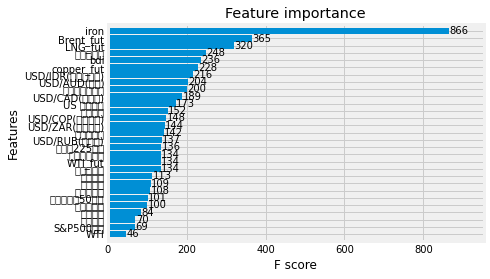

In [45]:
XG_model_month = xgb.XGBRegressor(learning_rate=0.1,max_depth=6,n_estimators=200)
XG_model_month.fit(df_train_x, df_train_y, eval_set=[(df_test_x, df_test_y)], early_stopping_rounds=100,verbose=False)

# 주요하게 적용하는 변수를 판단
plot_importance(XG_model_month, height=0.9)

###result

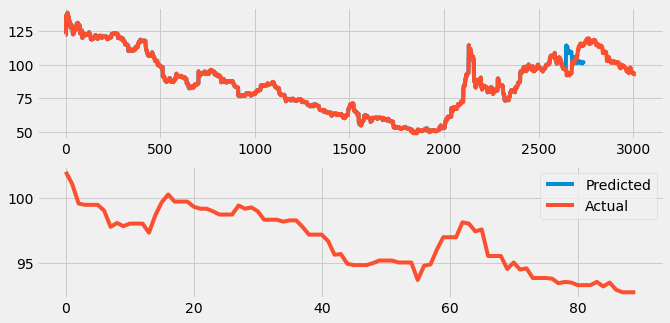

In [68]:
# 테스트 데이터 중 특정 store/item 데이터를 추출


xgboost = XG_model_month.predict(df_predict_x)

# 실제 값과 예측 값을 하나의 DataFrame으로 만들고 visualize
result=pd.concat([df_test_orig.reset_index(), pd.DataFrame(xgboost, columns=['xgboost'])], axis=1, ignore_index=False)
# result = result.set_index('date')
result = result.loc[:, ['Coal_price', 'xgboost']]

df_con=pd.concat([df_train['Coal_price'],df_test['Coal_price']],axis=0)
df_con=pd.concat([df_con,result['xgboost']],axis=0)
con = pd.DataFrame(df_con)

plt.figure(figsize=(10,5))
plt.subplot(211)
plt.plot(con.values , label='Predicted')
plt.plot(df_coal['Coal_price'].values , label='Actual')


plt.subplot(212)
plt.plot(result['xgboost'].values, label='Predicted')
plt.plot(df_coal['Coal_price'][-90:].values, label='Actual')
plt.legend()
plt.show()

Max_depth 20

[04:48:27] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


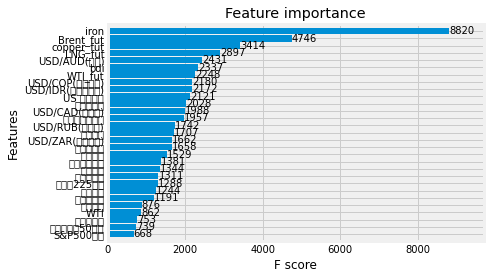

In [47]:
XG_model_month = xgb.XGBRegressor(n_estimators=1000, max_depth= 20)
XG_model_month.fit(df_train_x, df_train_y, eval_set=[(df_test_x, df_test_y)], early_stopping_rounds=100,verbose=False)

# 주요하게 적용하는 변수를 판단
plot_importance(XG_model_month, height=0.9)

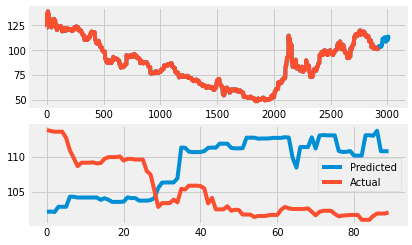

In [48]:
# 테스트 데이터 중 특정 store/item 데이터를 추출


xgboost = XG_model_month.predict(df_predict_x)

# 실제 값과 예측 값을 하나의 DataFrame으로 만들고 visualize
result=pd.concat([df_test_orig.reset_index(), pd.DataFrame(xgboost, columns=['xgboost'])], axis=1, ignore_index=False)
# result = result.set_index('date')
result = result.loc[:, ['Coal_price', 'xgboost']]

df_con=pd.concat([df_train['Coal_price'],df_test['Coal_price']],axis=0)
df_con=pd.concat([df_con,result['xgboost']],axis=0)
con = pd.DataFrame(df_con)

plt.subplot(211)
plt.plot(con.values , label='Predicted')
plt.plot(df_coal['Coal_price'].values , label='Actual')


plt.subplot(212)
plt.plot(result['xgboost'].values, label='Predicted')
plt.plot(df_coal['Coal_price'][-90:].values, label='Actual')
plt.legend()
plt.show()

Max_depth 30

[04:48:39] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


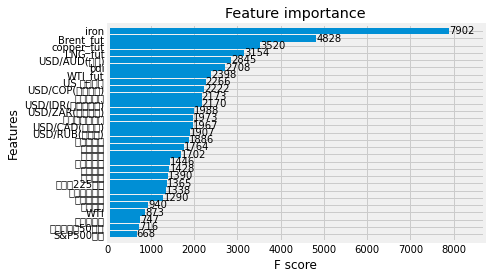

In [49]:
XG_model_month = xgb.XGBRegressor(n_estimators=1000, max_depth= 30)
XG_model_month.fit(df_train_x, df_train_y, eval_set=[(df_test_x, df_test_y)], early_stopping_rounds=100,verbose=False)

# 주요하게 적용하는 변수를 판단
plot_importance(XG_model_month, height=0.9)

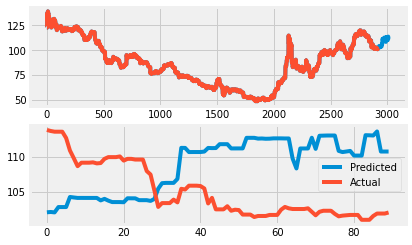

In [50]:
# 테스트 데이터 중 특정 store/item 데이터를 추출


xgboost = XG_model_month.predict(df_predict_x)

# 실제 값과 예측 값을 하나의 DataFrame으로 만들고 visualize
result=pd.concat([df_test_orig.reset_index(), pd.DataFrame(xgboost, columns=['xgboost'])], axis=1, ignore_index=False)
# result = result.set_index('date')
result = result.loc[:, ['Coal_price', 'xgboost']]

df_con=pd.concat([df_train['Coal_price'],df_test['Coal_price']],axis=0)
df_con=pd.concat([df_con,result['xgboost']],axis=0)
con = pd.DataFrame(df_con)

plt.subplot(211)
plt.plot(con.values , label='Predicted')
plt.plot(df_coal['Coal_price'].values , label='Actual')


plt.subplot(212)
plt.plot(result['xgboost'].values, label='Predicted')
plt.plot(df_coal['Coal_price'][-90:].values, label='Actual')
plt.legend()
plt.show()

##2.7 recursive - 1month val

*   30개 변수 prophe prediction 값 
*   y_pred값을 validation셋에 추가

*   결과값이 좀 보여서 다른 기간내에 적용해보기




Data

*   df는 실제값으로 2018년도 12월 31일까지
*   df_pred는 prophet으로 prediction한 값 2019년부터 1월 1일까지 (Coal_price 제외)
*   df_merge에 예측에 필요한 coal_price값 제외하고 merge






In [51]:
df = pd.read_excel("/content/gdrive/My Drive/Black_coal/data/dataset/project_dataset.xlsx")
df = df.sort_values('date')
df['date']= pd.to_datetime(df['date'])

df = df.set_index('date')
df = df[df.index < '2019-01-01']
df = df.reset_index()

In [52]:
df_pred = pd.read_csv("/content/gdrive/My Drive/Black_coal/data/dataset/prophet_pred/prophet_pred_final.csv", encoding = 'utf-8-sig')
df_pred = df_pred.rename(columns ={'ds':'date'})
df_pred['date']= pd.to_datetime(df_pred['date'])

df_pred = df_pred.set_index('date')
df_pred = df_pred.reset_index()


In [53]:
df_merge = pd.merge(df, df_pred, on=['date', 'Brent_fut', 'iron', 'copper_fut', 'WTI_fut', 'WTI', 'LNG_fut',
       'bdi', 'USD/AUD(호주)', 'USD/CAD(캐나다)', 'USD/COP(콜롬비아)', 'US 달러지수',
       'USD/IDR(인도네시아)', 'USD/RUB(러시아)', 'USD/ZAR(자메이카)', '상하이종합지수', '인도지수',
       '브라질지수', '다우존스지수', '프랑스지수', '영국지수', '독일지수', 'S&P500지수', '항셍지수', '나스닥지수',
       '코스피지수', '니케이225지수', '유로스톡스50지수', '호주지수', '캐나다지수'], how='outer')
       
df_merge = df_merge[['date', 'Coal_price', 'Brent_fut', 'iron', 'copper_fut', 'WTI_fut', 'WTI', 'LNG_fut',
       'bdi', 'USD/AUD(호주)', 'USD/CAD(캐나다)', 'USD/COP(콜롬비아)', 'US 달러지수',
       'USD/IDR(인도네시아)', 'USD/RUB(러시아)', 'USD/ZAR(자메이카)', '상하이종합지수', '인도지수',
       '브라질지수', '다우존스지수', '프랑스지수', '영국지수', '독일지수', 'S&P500지수', '항셍지수', '나스닥지수',
       '코스피지수', '니케이225지수', '유로스톡스50지수', '호주지수', '캐나다지수']]
df_merge['date']= pd.to_datetime(df_merge['date'])



In [54]:
df_drop = df_merge.drop('date',axis=1)


In [55]:
df_coal = pd.read_csv("/content/gdrive/My Drive/Black_coal/data/dataset/project_dataset.csv", encoding = 'utf-8-sig')
df_coal = df_coal.sort_values('date')
df_coal['date']= pd.to_datetime(df_coal['date'])

df_coal = df_coal.set_index('date')
df_coal = df_coal[df_coal.index < '2019-04-01']

df_coal = df_coal.reset_index()
df_coal = df_coal[['date','Coal_price']]


In [56]:
df_merge = df_merge.set_index('date')

In [57]:
df_merge[:"2018-12-31"]

,Coal_price,Brent_fut,iron,copper_fut,WTI_fut,WTI,LNG_fut,bdi,USD/AUD(호주),USD/CAD(캐나다),...,영국지수,독일지수,S&P500지수,항셍지수,나스닥지수,코스피지수,니케이225지수,유로스톡스50지수,호주지수,캐나다지수
date,,,,,,,,,,,,,,,,,,,,,
2011-01-01,122.65,94.75,168.3,9644.00,91.38,91.40,61.07,1773.0,0.98447,0.99960,...,5899.899902,6914.189941,1257.640015,23035.449219,2652.870117,2051.000000,10228.919922,2807.040039,4745.200195,13443.200195
2011-01-02,122.65,94.75,168.3,9644.00,91.38,91.40,61.07,1773.0,0.98447,0.99960,...,5899.899902,6914.189941,1257.640015,23035.449219,2652.870117,2051.000000,10228.919922,2807.040039,4745.200195,13443.200195
2011-01-03,136.50,94.84,170.0,9644.00,91.55,91.56,61.07,1773.0,0.97901,0.99270,...,5899.899902,6989.740234,1271.869995,23436.050781,2691.520020,2070.080078,10228.919922,2839.429932,4745.200195,13443.200195
2011-01-04,137.30,93.53,172.1,9619.25,89.38,89.23,58.32,1693.0,0.98337,0.99239,...,6013.899902,6975.350098,1270.199951,23668.480469,2681.250000,2085.139893,10398.099609,2844.169922,4742.500000,13402.299805
2011-01-05,130.65,95.50,174.5,9586.00,90.30,90.38,56.40,1621.0,0.99285,0.99700,...,6043.899902,6939.819824,1276.560059,23757.820312,2702.199951,2082.550049,10380.769531,2833.739990,4714.899902,13396.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2018-12-27,101.55,52.16,69.0,5972.00,44.61,45.23,64.36,1271.0,1.41347,1.35730,...,6584.700195,10381.509766,2488.830078,25478.880859,6579.490234,2028.439941,20077.619141,2937.360107,5597.200195,14165.200195
2018-12-28,101.90,52.20,69.2,5992.25,45.33,44.92,62.63,1271.0,1.42140,1.36190,...,6734.000000,10558.959961,2485.739990,25504.199219,6584.520020,2041.040039,20014.769531,2986.530029,5654.299805,14222.000000
2018-12-29,101.90,52.20,69.2,5992.25,45.33,44.92,62.63,1271.0,1.42140,1.36190,...,6734.000000,10558.959961,2485.739990,25504.199219,6584.520020,2041.040039,20014.769531,2986.530029,5654.299805,14222.000000


In [58]:
for i in range (89):
    
  
  # 학습과 테스트 데이터 분리
  split =  len(df_merge[:"2018-12-31"])
  # split1 =  len(df_merge[:"2018-12-31"])
  
  df_train = df_drop[:split+i]
  # df_test = df_drop[split+i:split1+i]
  df_predict = df_drop[len(df_merge[:"2018-12-31"]):len(df_merge[:"2019-01-01"])]

  df_train_y = df_train.loc[:,'Coal_price']
  df_train_x = df_train.drop('Coal_price', axis=1)
  df_test_y = df_test.loc[:,'Coal_price']
  df_test_x = df_test.drop('Coal_price', axis=1)
  # 나중에 예측값과 비교하기 위해 test 데이터 복제본 저장
  df_test_orig = df_coal.loc[:, 'Coal_price']
  df_predict_x = df_predict.drop('Coal_price', axis=1)
  df_predict_x = df_predict_x[:]



  XG_model_month = xgb.XGBRegressor(learning_rate=0.1,max_depth=6,n_estimators=200)
  XG_model_month.fit(df_train_x, df_train_y, eval_set=[(df_train_x, df_train_y)], early_stopping_rounds=100,verbose=False)
  
  xgboost = XG_model_month.predict(df_predict_x)

  # 실제 값과 예측 값을 하나의 DataFrame으로 만들고 visualize
  result=pd.concat([df_test_orig.reset_index(), pd.DataFrame(xgboost, columns=['xgboost'])], axis=1, ignore_index=False)
  
  df_drop['Coal_price'][len(df_merge[:"2018-12-31"])+i]=result['xgboost'][0]
  # df_drop['shift'][len(df_merge[:"2019-01-01"])+i]=result['xgboost'][0]
  print(df_drop['Coal_price'][len(df_merge[:"2018-12-31"])]+i)
  # print(df_drop['shift'][len(df_merge[:"2019-01-01"])]+i)

[04:48:54] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
111.84369659423828
[04:48:56] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
112.84369659423828
[04:48:59] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
113.84369659423828
[04:49:01] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
114.84369659423828
[04:49:03] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
115.84369659423828
[04:49:06] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
116.84369659423828
[04:49:08] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederro

###result

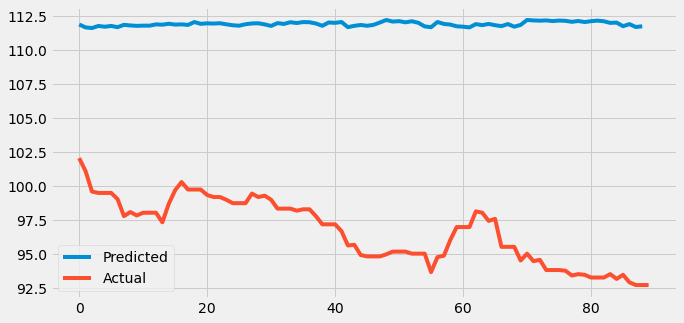

In [59]:
plt.style.use('fivethirtyeight')
plt.figure(figsize=(10,5))

plt.plot(df_drop['Coal_price'][-90:].values, label='Predicted')
plt.plot(df_coal['Coal_price'][-90:].values, label='Actual')
plt.legend()
plt.show()

##2.2 recursive / (t-1Coal_price)



*  t-1시점의 y데이터 추가
- recursive model






In [60]:
df2 = pd.read_excel("/content/gdrive/My Drive/Black_coal/data/dataset/project_dataset.xlsx")
df2 = df2.sort_values('date')
df2['date']= pd.to_datetime(df2['date'])

df2 = df2.set_index('date')
df2 = df2[df2.index < '2019-01-02']
df2 = df2.reset_index()
df2 = df2[['date','Coal_price']] 
df2 = df2.rename(columns ={'date':'ds'})
shift= df2['Coal_price'].shift(1)
shift[0]=df2['Coal_price'][0]

shift2 = df2[['ds','Coal_price']]
shift2=df2.rename(columns={'Coal_price' : 'shift'})
shift2['shift']=shift
shift2



,ds,shift
0,2011-01-01,122.65
1,2011-01-02,122.65
2,2011-01-03,122.65
3,2011-01-04,136.50
4,2011-01-05,137.30
...,...,...
2918,2018-12-28,101.55
2919,2018-12-29,101.90
2920,2018-12-30,101.90
2921,2018-12-31,101.90


In [61]:
df_merge=df_merge.reset_index()

In [62]:
df_merge=df_merge.rename(columns={'date':'ds'})
df_merge

,ds,Coal_price,Brent_fut,iron,copper_fut,WTI_fut,WTI,LNG_fut,bdi,USD/AUD(호주),...,영국지수,독일지수,S&P500지수,항셍지수,나스닥지수,코스피지수,니케이225지수,유로스톡스50지수,호주지수,캐나다지수
0,2011-01-01,122.65,94.750000,168.300000,9644.000000,91.380000,91.400000,61.070000,1773.000000,0.984470,...,5899.899902,6914.189941,1257.640015,23035.449219,2652.870117,2051.000000,10228.919922,2807.040039,4745.200195,13443.200195
1,2011-01-02,122.65,94.750000,168.300000,9644.000000,91.380000,91.400000,61.070000,1773.000000,0.984470,...,5899.899902,6914.189941,1257.640015,23035.449219,2652.870117,2051.000000,10228.919922,2807.040039,4745.200195,13443.200195
2,2011-01-03,136.50,94.840000,170.000000,9644.000000,91.550000,91.560000,61.070000,1773.000000,0.979010,...,5899.899902,6989.740234,1271.869995,23436.050781,2691.520020,2070.080078,10228.919922,2839.429932,4745.200195,13443.200195
3,2011-01-04,137.30,93.530000,172.100000,9619.250000,89.380000,89.230000,58.320000,1693.000000,0.983370,...,6013.899902,6975.350098,1270.199951,23668.480469,2681.250000,2085.139893,10398.099609,2844.169922,4742.500000,13402.299805
4,2011-01-05,130.65,95.500000,174.500000,9586.000000,90.300000,90.380000,56.400000,1621.000000,0.992850,...,6043.899902,6939.819824,1276.560059,23757.820312,2702.199951,2082.550049,10380.769531,2833.739990,4714.899902,13396.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3007,2019-03-27,NaN,84.124730,72.446181,6703.428741,74.566090,74.733597,71.442419,1402.027680,1.372171,...,7298.123222,11897.295010,2918.493060,29237.210404,8123.580208,2252.528334,23546.358166,3263.093898,6171.147374,15954.943396
3008,2019-03-28,NaN,84.199753,72.354536,6691.270487,74.562116,74.750119,71.307777,1399.854283,1.373349,...,7290.969546,11893.885654,2919.238593,29209.282776,8123.496620,2252.020118,23542.239644,3261.886242,6175.229169,15943.334716
3009,2019-03-29,NaN,84.291781,72.370737,6683.270496,74.628844,74.817677,71.206234,1396.475330,1.374941,...,7287.452489,11888.538235,2919.920821,29195.805869,8122.842283,2249.926048,23541.187552,3259.948145,6176.074040,15927.833254
3010,2019-03-30,NaN,84.363165,72.375087,6673.171699,74.731828,74.938001,71.049927,1390.815421,1.376403,...,7283.986305,11884.435037,2920.547457,29173.373865,8122.769151,2247.524109,23537.235686,3257.373048,6176.594855,15915.512454


In [63]:
df_merge = pd.merge(df_merge,shift2,on='ds',how='outer')
df_merge

,ds,Coal_price,Brent_fut,iron,copper_fut,WTI_fut,WTI,LNG_fut,bdi,USD/AUD(호주),...,독일지수,S&P500지수,항셍지수,나스닥지수,코스피지수,니케이225지수,유로스톡스50지수,호주지수,캐나다지수,shift
0,2011-01-01,122.65,94.750000,168.300000,9644.000000,91.380000,91.400000,61.070000,1773.000000,0.984470,...,6914.189941,1257.640015,23035.449219,2652.870117,2051.000000,10228.919922,2807.040039,4745.200195,13443.200195,122.65
1,2011-01-02,122.65,94.750000,168.300000,9644.000000,91.380000,91.400000,61.070000,1773.000000,0.984470,...,6914.189941,1257.640015,23035.449219,2652.870117,2051.000000,10228.919922,2807.040039,4745.200195,13443.200195,122.65
2,2011-01-03,136.50,94.840000,170.000000,9644.000000,91.550000,91.560000,61.070000,1773.000000,0.979010,...,6989.740234,1271.869995,23436.050781,2691.520020,2070.080078,10228.919922,2839.429932,4745.200195,13443.200195,122.65
3,2011-01-04,137.30,93.530000,172.100000,9619.250000,89.380000,89.230000,58.320000,1693.000000,0.983370,...,6975.350098,1270.199951,23668.480469,2681.250000,2085.139893,10398.099609,2844.169922,4742.500000,13402.299805,136.50
4,2011-01-05,130.65,95.500000,174.500000,9586.000000,90.300000,90.380000,56.400000,1621.000000,0.992850,...,6939.819824,1276.560059,23757.820312,2702.199951,2082.550049,10380.769531,2833.739990,4714.899902,13396.000000,137.30
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3007,2019-03-27,NaN,84.124730,72.446181,6703.428741,74.566090,74.733597,71.442419,1402.027680,1.372171,...,11897.295010,2918.493060,29237.210404,8123.580208,2252.528334,23546.358166,3263.093898,6171.147374,15954.943396,NaN
3008,2019-03-28,NaN,84.199753,72.354536,6691.270487,74.562116,74.750119,71.307777,1399.854283,1.373349,...,11893.885654,2919.238593,29209.282776,8123.496620,2252.020118,23542.239644,3261.886242,6175.229169,15943.334716,NaN
3009,2019-03-29,NaN,84.291781,72.370737,6683.270496,74.628844,74.817677,71.206234,1396.475330,1.374941,...,11888.538235,2919.920821,29195.805869,8122.842283,2249.926048,23541.187552,3259.948145,6176.074040,15927.833254,NaN
3010,2019-03-30,NaN,84.363165,72.375087,6673.171699,74.731828,74.938001,71.049927,1390.815421,1.376403,...,11884.435037,2920.547457,29173.373865,8122.769151,2247.524109,23537.235686,3257.373048,6176.594855,15915.512454,NaN


In [64]:
df_drop = df_merge.drop('ds',axis=1)

In [65]:
df_merge=df_merge.set_index('ds')

In [66]:
for i in range (89):
    
  
  # 학습과 테스트 데이터 분리
  split =  len(df_merge[:"2017-12-31"])
  # split1 =  len(df_merge[:"2018-12-31"])
  
  df_train = df_drop[:split+i]
  # df_test = df_drop[split+i:split1+i]
  df_predict = df_drop[len(df_merge[:"2018-12-31"]):len(df_merge[:"2019-01-01"])]

  df_train_y = df_train.loc[:,'Coal_price']
  df_train_x = df_train.drop('Coal_price', axis=1)
  df_test_y = df_test.loc[:,'Coal_price']
  df_test_x = df_test.drop('Coal_price', axis=1)
  # 나중에 예측값과 비교하기 위해 test 데이터 복제본 저장
  df_test_orig = df_coal.loc[:, 'Coal_price']
  df_predict_x = df_predict.drop('Coal_price', axis=1)
  df_predict_x = df_predict_x[:]



  XG_model_month = xgb.XGBRegressor(learning_rate=0.1,max_depth=6,n_estimators=200)
  XG_model_month.fit(df_train_x, df_train_y, eval_set=[(df_train_x, df_train_y)], early_stopping_rounds=100,verbose=False)
  
  xgboost = XG_model_month.predict(df_predict_x)

  # 실제 값과 예측 값을 하나의 DataFrame으로 만들고 visualize
  result=pd.concat([df_test_orig.reset_index(), pd.DataFrame(xgboost, columns=['xgboost'])], axis=1, ignore_index=False)
  
  df_drop['Coal_price'][len(df_merge[:"2018-12-31"])+i]=result['xgboost'][0]
  df_drop['shift'][len(df_merge[:"2019-01-01"])+i]=result['xgboost'][0]
  print(df_drop['Coal_price'][len(df_merge[:"2018-12-31"])]+i)
  print(df_drop['shift'][len(df_merge[:"2019-01-01"])]+i)

[04:52:36] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
103.24754333496094
103.24754333496094
[04:52:38] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
104.24754333496094
104.24754333496094
[04:52:40] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
105.24754333496094
105.24754333496094
[04:52:43] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
106.24754333496094
106.24754333496094
[04:52:45] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
107.24754333496094
107.24754333496094
[04:52:47] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
108.24754333496094
108.24754333496094
[04:52:49]

###result

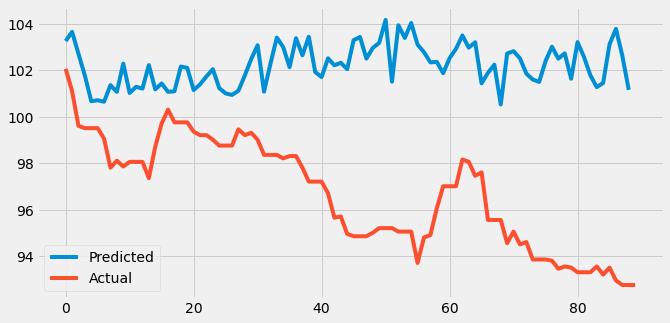

In [67]:
plt.figure(figsize=(10,5))
plt.plot(df_drop['Coal_price'][-90:].values, label='Predicted')
plt.plot(df_coal['Coal_price'][-90:].values, label='Actual')
plt.legend()
plt.show()

#prameter 정리

● 파라미터
1) General parameter
- 트리 또는 선형 모델에서 부스팅을 수행하는 데 사용하는 부스터와 관련된 파라미터이다.
2) Booster parameter
- 선택한 부스터의 파라미터에 따라 다름. 이글에서는 Tree Booster parameter를 설명할 예정
3) Learning task parameter
- 학습 시나리오를 결정한다. Regression은 Ranking 같은 파라미터와 다른 것들을 함께 사용할 수 있다.

1) General
- booster
:[gbtree, gblinear, dart] 중 하나(기본값 :gbtree)
- verbosity
:출력 메시지 레벨(기본값 : 1)
:[0 (silent), 1 (warning), 2 (info), 3 (debug)] 중 하나
- validate_parameters
기본값 : false
파라미터유효성 검사
설정. 여러 파라미터들을 설정하다 보면 서로 모순되는 값들을 넣는 실수를 하는 실수를 방지해준다.
아직 실험단계이다. 파이썬에선 지원되지 않기 때문에 나는 사용해본 적 없음.
- nthread
기본값 :최대
학습에 사용할 thread수.
ML전용 컴퓨터를 사용하기 때문에 따로 건드린 적 없이 기본값으로 최대만 사용해보았음.
- disable_default_eval_metric
기본값: 0
0이면 기본 metric 사용, 아니면 기본 metric을 사용하지 않는다.
커스텀 metric을 사용할 경우 설정한다.
- num_pbuffer
기본값 : 자동으로 설정
마지막 부스팅 단계의 예측 결과를 저장하는 버퍼의 크기
자동으로 설정되기에 건드린 적 없음.
- num_feature
기본값 : 인풋 피쳐의 수와 동일하게 설정됨
부스팅에 사용되는 피쳐 수.
자동으로 설정되기에 건드린 적 없음.



2) booster Parameter
- eta [alias: learning_rate]
: 기본값 :0.3 / 범위 : [0,1] 
: 학습률. 낮은 값일수록 모델이 견고해지고 오버 피팅 방지에 좋다.
: 일반적으로0.01 ~ 0.3 정도로 설정하는데, 
제한된 리소스를 가진 기계에 모델을 올려야 할 경우 Step 수를 줄이기 위해 0.9까지 올려 모델 크기를 최소화한 적도 있다. 일반적인 상황이라면 권장하지 않는다.
- gamma [alias: min_split_loss]
기본값 :0 / 범위 : [0,∞]
이전 글에서 언급한 gain 값이 gamma 이상일 경우 자식 노드를 생성하도록 한다.
Overfitting 방지에 좋으나 너무 높으면 underfitting 이 생길 수가 있음.
lambda, alpha 값에도 영향을 받기 때문에, 파라미터 튜닝 시 세 가지를 동시에 바꿔가며 grid search를 하는 편
- max_depth
기본값 :6 / 범위 : [0,∞]
최대 트리의 깊이. N이라고 가정하면 2^N개의 리프 노드가 생긴다. 10일 때 최대 1024개의 리프 노트가 생긴다.
일반적으로 Feature 수에 따라 3~6으로 세팅한 후 성능이 증가하고, 오버 피팅이 나지 않을 때까지 늘려간다.
제한된 리소스에 모델을 올려야 할 경우 울며 겨자 먹기로 약간의 성능을 포기하고 depth를 줄이기도 한다.
- subsample
기본값 : 1 범위: (0,1]
각각의 스탭마다 사용할 샘플의 비율. 1 이하의 값을 사용하면 오버 피팅을 방지할 수 있다.
개인적으로 cross validation을 주로 쓴다면 크게 중요한 파라미터가 아닌 것 같다.
- sampling_method
기본값 : uniform
subsample을 1 이하로 설정한다면 샘플을 뽑는지 정의한다.
[uniform, gradient_based] 중 하나
subsample은 data자체를 샘플링하는 것이고 colsample_* 파라미터는 feature를 샘플링하는 것이다.
colsample_* 파라미터는 feature가 너무 많거나 소수의 feature에 지나치게 의존적일 때 사용하면 좋음.
colsample_bytree
기본값 : 1 / 범위 : (0,1]
각각의 트리(스탭)마다 사용할 칼럼(Feature)의 비율
개인적으로colsample_* 파라미터 둘 중에 가장 효과가 좋은 것 같음.
colsample_bylevel
기본값 : 1 / 범위 : (0,1]
각각의 트리 depth 마다 사용할 칼럼(Feature)의 비율
colsample_bynode
기본값 : 1 / 범위 : (0,1]
각각의 노드 depth 마다 사용할 칼럼(Feature)의 비율
colsample_bylevel와 비슷해 보이지만 이 경우 좌, 우 리프 노드가 서로 다른 feature를 사용하게 된다.
lambda [alias: reg_lambda]
기본값 :1 / 범위 : [0,∞]
L2 정규화(규제) 파라미터이다.
커질수록 보수적인 모델을 생성하고 오버 피팅을 방지해준다. 지나치게 클 경우 언더 피팅이 난다. 
너무 큰 가중치를 그 크기에 비례하여 줄여준다.
noise나 outlier 같은 애들이나 너무 크게 튀는 데이터들을 어느 정도 잡아준다고 보면 된다. 
gamma, alpha와 함께 튜닝함.
- alpha [alias: reg_alpha]
기본값 :0 / 범위: [0,∞]
L1 정규화(규제) 파라미터이다.
커질수록 보수적인 모델을 생성하고 오버 피팅을 방지해준다.
불필요한 가중치를 0으로 만들어서 무시하도록 한다. 
sparse feature 가 있거나 feature수가 지나치게 많을 때 효과적이다.
gamma, lambda와 함께 튜닝함.
- scale_pos_weight
[default=1]
데이터 클래스(레이블) 불균형이 있을 때 레이블 가중치를 조절해주는 파라미터
권장값 : sum(negative instances) / sum(positive instances)
왜 끝에 설명하는지 모르겠지만 굉장히 중요한 파라미터. 데이터 불균형이 심한 경우 꼭 설정해주는 게 좋다.

3) Learning Task Parameters
- objective
기본값 :reg:squarederror
목적함수이다. 이 함수를 통해 나온 값이 최소화되는 방향으로 학습된다.
종류가 너무 다양해 자주 쓰는 것들만 설명하자면
reg:squarederror / reg:squaredlogerror : 오차 제곱 / 오차 로그 제곱
binary:logistic : 이항 분류(binary class)에 사용. 이항 분류는 대부분 이놈만 쓴다.
multi:softmax / multi:softprob : 다항 분류(multi class)에 사용.
rank:pairwise / rank:ndcg / rank:map : l2r에 사용
- base_score
기본값 :0.5
초기 편향치(bias)이다.
범위가 0~1 사이가 아닌 값을 예측하는 경우 이 값을 그 중간 값으로 설정해주면 가끔 성능이 좋아지거나 빨리 종료되기도 한다.
- eval_metric
기본값 : objective에 따라 다름.
평가 지표이다. 각 스텝마다 완성된 모델을 이 지표를 통해서 평가한다.
이것도 너무 많으므로 자주 쓴 것들만 설명.
rmse /rmsle : 글자 그대로 역순으로 해석하면 된다. 에러 (로그) 제곱 평균의 루트 값
mae : 오차 절댓값 평균
error /error@t : 이항 분류(binary class)에서 error는 0.5 이상을 1 미만을 0이라고 판단하고 error@t는 t 이상을 1 미만을 0이라고 판단한다.
merror : error의 다항 분류(multi class) 버전
auc :auc는 area under curve의 약자로 즉 곡선 아래의 면적 이란 뜻이다. 보통 auc라고 하면 roc auc을 뜻한다. FPR과 TPR에 민감한 데이터 셋 일 경우 사용한다.
aucpr :auc뒤에 붙은 pr은 preicison recall을 뜻한다. f-score나 precision, recall에 민감할 때 사용한다.(error나 rmse가 더 잘 나오는 경우도 많으니 다 해봐야 함.)
- seed
기본값 : 0
랜덤시드이다. 같은 데이터 셋으로 여러 모델을 비교할 때는 같은 값으로 설정하고 비교해야 한다.

4) 기타
- num_boost_round
기본값 : 의무 설정 / 범위: [0,∞]
몇 회의 step을 반복할지 지정한다. 너무 높은 값을 사용하면 오버 피팅이 생기고 모델의 사이즈가 커진다.
- early_stopping_rounds
기본값 : 설정하지 않을 경우 비활성화. / 범위: [0,∞]
조기 종료 조건이다.
eval_metric이 결과가  early_stopping_rounds 횟수 동안 개선되지 않으면 num_boost_round에 도달하기 전에 종료한다.

사이킷런래퍼 :하이퍼파라미터 튜닝
* 파라미터 튜닝에 들이는 노력 대비 성능 향상 효과가 높지 않은 경우가 많으므로 주의
- learning_rate :학습률 (default : 0.1)
- n_estimators : 학습 모델 개수(반복 수행 횟수) 
- min_child_weight : default 1 - 클수록 분할을 자제(과적합 제어)
- gamma : default 0 - 리프 노드를 추가적으로 나눌지 결정하는 최소 손실 감소값 (값이 클수록 과적합 제어)
- max_depth : 트리의 최대 깊이 (default : 6)
- subsample : 학습에 사용하는 데이터 샘플링 비율(default 1) - 과적합이 염려되는 경우 1보다 작게 설정
- reg_lambda&reg_alpha :과적합 제어를 위한 규제 적용
- colsample_bytree : 트리 생성에 필요한 피처를 지정 비율로 샘플링(많은 피처가 있는 경우 과적합 제어 가능)
- scale_pos_weight : 특정 값으로 치우친 비대칭 클래스의 데이터 세트 균형 유지


